# Exploratory and speculative visualizations

### 0. Bootstrap & Environment

This notebook explores **illustrative models of Galactic disk evolution** using
real stellar distributions as anchors and stylized kinematic prescriptions.

The bootstrap cell:
- resolves project paths (`TOPIC_ROOT`, `PROC`, `ANIM_DIR`);
- fixes animation defaults (FPS, DPI, writers);
- guarantees **CSV-only data flow** (no in-memory coupling).

All subsequent cells rely exclusively on this bootstrap context.

In [13]:
# =========================================================
# Cell 0 — Universal bootstrap (globals, paths, theme, i18n)
# Works for: ACAP_* and ANIM_*
# =========================================================

from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th
from astroquery.vizier import Vizier
from tqdm import tqdm
import lulab.i18n.plot_text as pt
import lulab.anim.defaults as animd
from lulab.anim.defaults import save_animation

# -----------------------------
# External services (Vizier)
# -----------------------------
# No row limit by default
Vizier.ROW_LIMIT = -1

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ANIM_003"   # e.g. "ACAP_001", "ANIM_001"
LANG: str = "en"             # "en" / "ru"
THEME: str = "light"          # "light" / "dark"

# -----------------------------
# Animation export settings (safe to keep for ACAP too)
# -----------------------------
ANIM_FORMAT = "gif"       # "gif" / "mp4"
FPS = 24
DPI = 200

MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"
GIF_LOOP = 0

# sync notebook settings -> module defaults used by save_animation()
animd.ANIM_FORMAT  = ANIM_FORMAT
animd.FPS          = FPS
animd.DPI          = DPI
animd.MP4_CODEC    = MP4_CODEC
animd.MP4_BITRATE  = MP4_BITRATE
animd.GIF_LOOP     = GIF_LOOP

# --- physical limits (keep consistent) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Common paths
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)

DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)

ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# --- legacy aliases (do NOT remove, used in older cells) ---
RAW  = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR

# -----------------------------
# Theme
# -----------------------------
# Use a single consistent entry point everywhere
th.apply_theme(THEME)

# -----------------------------
# Save helpers
# -----------------------------
def save_fig0(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> build artifact ID:
        ANIM_001_Figure_3
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

def anim_outpath(anim_id: str, ext: str | None = None) -> Path:
    """
    Standard output path for animations.
    Example:
        out = anim_outpath("Orbit_1")  -> ANIM_DIR/ANIM_001_Orbit_1.mp4
        out = anim_outpath("Orbit_1", ext="gif")
    """
    if ext is None:
        ext = ANIM_FORMAT
    return ANIM_DIR / f"{NOTEBOOK}_{anim_id}.{ext}"

def save_last_frame(anim, fig_id: str):
    """
    Render animation sequentially to the final state (works for cumulative updates),
    then save the resulting figure via save_fig0().
    """
    fig = anim._fig

    # init (important)
    anim._init_draw()

    # sequentially draw all frames to build cumulative state
    last = None
    for framedata in anim.new_frame_seq():
        last = framedata
        anim._draw_next_frame(framedata, blit=False)

    if last is None:
        raise RuntimeError("Animation has no frames.")

    fig.canvas.draw()
    fig.canvas.flush_events()

    save_fig0(fig_id, fig=fig)
      

# -----------------------------
# i18n bootstrap (force reload to avoid stale imports)
# -----------------------------
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)

# convenience aliases (stable)
L = pt.L
T = pt.T

import re

def _slug(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def anim_base(name: str, *, notebook: str = NOTEBOOK) -> Path:
    """
    Returns ANIM_DIR / "<NOTEBOOK>_<slug(name)>" WITHOUT suffix.
    Use ONLY this with save_animation().
    """
    return (ANIM_DIR / f"{notebook}_{_slug(name)}")

# -----------------------------
# Quick sanity printout
# -----------------------------
print("\n--- BOOTSTRAP ---")
print("TOPIC      :", TOPIC)
print("NOTEBOOK   :", NOTEBOOK)
print("LANG       :", LANG)
print("THEME      :", THEME)
print("TOPIC_ROOT :", TOPIC_ROOT)
print("FIG_DIR    :", FIG_DIR)
print("DATA_RAW   :", DATA_RAW_DIR)
print("DATA_PROC  :", DATA_PROCESSED_DIR)
print("ANIM_DIR   :", ANIM_DIR)
print("ANIM_FORMAT:", animd.ANIM_FORMAT)
print("FPS / DPI  :", FPS, "/", DPI)


--- BOOTSTRAP ---
TOPIC      : TOP_0001_exoplanet_birth_radius
NOTEBOOK   : ANIM_003
LANG       : en
THEME      : light
TOPIC_ROOT : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
FIG_DIR    : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en
DATA_RAW   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw
DATA_PROC  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
ANIM_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
ANIM_FORMAT: gif
FPS / DPI  : 24 / 200


---

## Part I. Schematic radial migration: from birth radius to present-day position

In the following two animations we introduce a **schematic, illustrative view of radial migration in the Galactic disk**.  

These figures are **not direct measurements**, but controlled visual experiments designed to help interpret the statistical trends seen in the `APOGEE`×`Gaia` data.

### Concept and data basis

- We start from a **processed APOGEE×Gaia ISM proxy dataset**, containing present-day galactocentric radii $R_{\rm gal}$ and stellar metallicities $[\mathrm{Fe/H}]$.
- A **proxy for the ISM metallicity gradient** is constructed by computing the **binned median $[\mathrm{Fe/H}](R)$**.
- This median relation is then **inverted** to estimate a schematic **stellar birth radius $R_{\rm birth}$** for each star, under the assumption that stars inherit the ISM metallicity at their formation radius.
- No explicit ages are used here; the goal is to visualize **radial displacements**, not to reconstruct detailed evolutionary histories.

### Geometry and visualization choices

- The Galaxy is shown in a **top-down (face-on) view**.
- Each star is assigned a **random azimuthal angle**, preserving only its radial information.
- Migration is visualized as a **vector from $R_{\rm birth}$ to the present-day radius $R_{\rm gal}$**.
- Colors encode stellar metallicity $[\mathrm{Fe/H}]$, providing context for the inferred birth radii.

### Two complementary animation modes

1. **Static arrows (direct migration vectors)**  
   All migration vectors are drawn fully, revealing the overall pattern of inward and outward radial displacements across the disk.

2. **Time-like growth of migration vectors**  
   Migration vectors are revealed progressively:
   - stars appear in an **inside-out order**, sorted by inferred $R_{\rm birth}$,
   - vectors grow from birth to present position, mimicking a temporal buildup of radial migration.

### Interpretation and scope

These animations are intended as **qualitative schematics**:
- they illustrate how a metallicity gradient combined with radial mixing can redistribute stars across the Galactic disk,
- they help build intuition for later, more quantitative analyses,
- they should not be interpreted as a literal dynamical model or time-resolved reconstruction.

Together, the two views provide a compact visual summary of how **radial migration may blur the connection between present-day position and formation site** in the Milky Way disk.

---

## 1.1 Radial migration (birth → present)

Here stars **physically move** from birth radii to present-day radii.

Model ingredients:
- synthetic birth radius drawn from an evolving distribution;
- controlled inward/outward migration fractions;
- linear interpolation in time;
- Sun treated as a special illustrative tracer.

This animation answers:
> “What does large-scale radial migration *look like* if seen from outside?”

The motion is schematic but **kinematically intuitive**.

Loaded rows: 102800 | apogee_gaia_ism_proxy.csv
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_migration_schematic_mode_growing.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_migration_schematic_mode_growing.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_1.png


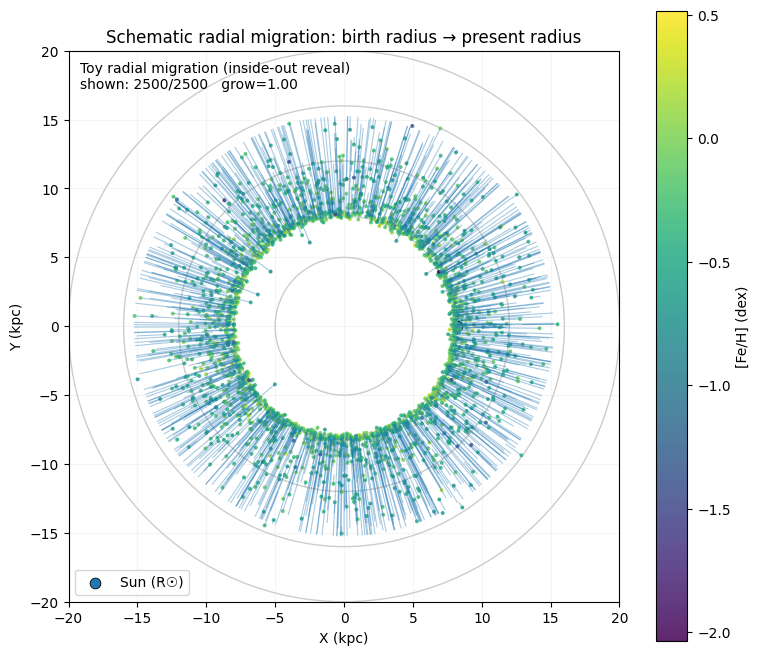

In [12]:
# =========================================================
# [ANIM_003|Cell C] Migration schematic over "time" (inside-out)
#   Birth radius inferred by inverting ISM proxy curve: median [Fe/H](R).
#   Reveals stars in "time" order (inside_out by r_birth) with vectors growing.
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

# -----------------------------
# 0) i18n text
# -----------------------------
X_X = L("x_kpc")
Y_Y = L("y_kpc")
C_FEH = L("feh")
SUN_LABEL = L("sun")

TITLE0 = T("anim_migration")
SUB_IN = T("anim_migration_sub_insideout")
SUB_RN = T("anim_migration_sub_random")


# -----------------------------
# 1) Load processed data
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(
        f"{NOTEBOOK} Cell C: missing processed CSV:\n  {SRC_PATH}\n"
        "Expected: columns ['R_gal','feh'] (+ optional 'Z_gal')."
    )

df = pd.read_csv(SRC_PATH).dropna(subset=["R_gal", "feh"]).copy()

# stable clip
df = df[(df["R_gal"] >= 0.0) & (df["R_gal"] <= 16.0)]
df = df[(df["feh"] > -2.5) & (df["feh"] < 1.0)]
print("Loaded rows:", len(df), "|", SRC_PATH.name)

R = df["R_gal"].astype(float).to_numpy()
feh = df["feh"].astype(float).to_numpy()

# -----------------------------
# 2) Build ISM proxy: median [Fe/H](R) in bins, then invert FeH->R_birth
# -----------------------------
rbins = np.linspace(7.5, 15.5, 17)   # as in your draft (tweakable)
rcent = 0.5 * (rbins[:-1] + rbins[1:])

med = np.full(len(rcent), np.nan)
nbin = np.zeros(len(rcent), dtype=int)

MIN_BIN_N = 400
for i in range(len(rcent)):
    sel = (R >= rbins[i]) & (R < rbins[i + 1])
    nbin[i] = int(sel.sum())
    if nbin[i] >= MIN_BIN_N:
        med[i] = np.nanmedian(feh[sel])

mask = np.isfinite(med)
r_med = rcent[mask]
feh_med = med[mask]

if len(r_med) < 5:
    raise RuntimeError(
        f"Not enough bins to build ISM proxy (need >= 5, got {len(r_med)}). "
        f"Try lowering MIN_BIN_N={MIN_BIN_N} or adjusting rbins."
    )

# Make monotonic for safe inversion:
# sort by FeH increasing; enforce strictly increasing FeH for interpolation
order = np.argsort(feh_med)
feh_sorted = feh_med[order].copy()
r_sorted = r_med[order].copy()

eps = 1e-6
for i in range(1, len(feh_sorted)):
    if feh_sorted[i] <= feh_sorted[i - 1]:
        feh_sorted[i] = feh_sorted[i - 1] + eps

def R_birth_from_feh(feh_vals: np.ndarray) -> np.ndarray:
    feh_vals = np.asarray(feh_vals, dtype=float)
    feh_clip = np.clip(feh_vals, feh_sorted.min(), feh_sorted.max())
    return np.interp(feh_clip, feh_sorted, r_sorted)

R_birth = R_birth_from_feh(feh)

# -----------------------------
# 3) Build top-down XY positions (random azimuth, consistent per star)
# -----------------------------
SEED = 1
rng = np.random.default_rng(SEED)
phi = rng.uniform(0, 2*np.pi, size=len(df))

x_now = R * np.cos(phi)
y_now = R * np.sin(phi)

x_birth = R_birth * np.cos(phi)
y_birth = R_birth * np.sin(phi)

# sample for readability
N_SHOW = 2500
if len(df) > N_SHOW:
    idx = rng.choice(len(df), size=N_SHOW, replace=False)
else:
    idx = np.arange(len(df))

x_now, y_now = x_now[idx], y_now[idx]
x_birth, y_birth = x_birth[idx], y_birth[idx]
feh_s = feh[idx]
rb_s  = R_birth[idx]

# ordering mode
MODE = "inside_out"   # "inside_out" or "random"
if MODE == "inside_out":
    ord_idx = np.argsort(rb_s)   # inner birth first
    subtitle = SUB_IN
else:
    ord_idx = rng.permutation(len(rb_s))
    subtitle = SUB_RN

x_now, y_now = x_now[ord_idx], y_now[ord_idx]
x_birth, y_birth = x_birth[ord_idx], y_birth[ord_idx]
feh_s = feh_s[ord_idx]

# full vectors as segments (birth -> now)
segs_full = np.stack(
    [np.column_stack([x_birth, y_birth]), np.column_stack([x_now, y_now])],
    axis=1
)

# -----------------------------
# 4) Plot styling
# -----------------------------
R_MAX = 20.0
R_SUN = 8.2

fig, ax = plt.subplots(figsize=(7.5, 7.5), constrained_layout=True)
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-R_MAX, R_MAX)
ax.set_ylim(-R_MAX, R_MAX)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.grid(alpha=0.18)

# guide circles
for rr in [5, 8, 12, 16, 20]:
    ax.add_patch(plt.Circle((0, 0), rr, fill=False, lw=1, alpha=0.20))

sun = ax.scatter([R_SUN], [0], s=60, marker="o", edgecolors="k", linewidths=0.6, label=SUN_LABEL)

# present positions colored by FeH
sc = ax.scatter(x_now, y_now, c=feh_s, s=8, alpha=0.85, linewidths=0, cmap="viridis")
cbar = fig.colorbar(sc, ax=ax, shrink=0.85)
cbar.set_label(C_FEH)

# migration vectors (LineCollection)
lc = LineCollection([], linewidths=0.8, alpha=0.38)
ax.add_collection(lc)

txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left", fontsize=10)
ax.legend(loc="lower left", frameon=True)

# -----------------------------
# 5) Animation timing (3 sec reveal + 3 sec hold)
# -----------------------------
REVEAL_SEC = 3
HOLD_SEC   = 3
N_FRAMES_REVEAL = int(FPS * REVEAL_SEC)
N_FRAMES_HOLD   = int(FPS * HOLD_SEC)
N_FRAMES        = max(2, N_FRAMES_REVEAL + N_FRAMES_HOLD)

def init():
    lc.set_segments([])
    ax.set_title(TITLE0)
    txt.set_text("")
    return (sc, sun, lc, txt)

def update(frame):
    if frame < N_FRAMES_REVEAL:
        t = frame / max(1, (N_FRAMES_REVEAL - 1))
        n = max(1, int(len(segs_full) * t))
        grow = t
    else:
        n = len(segs_full)
        grow = 1.0

    # grow vectors partially: end point moves from birth toward now
    segs = segs_full[:n].copy()
    p0 = segs[:, 0, :]
    p1 = segs[:, 1, :]
    p1g = p0 + grow * (p1 - p0)
    segs[:, 1, :] = p1g

    lc.set_segments(segs)

    ax.set_title(TITLE0)
    txt.set_text(f"{subtitle}\nshown: {n}/{len(segs_full)}   grow={grow:.2f}")
    return (sc, sun, lc, txt)


# -----------------------------
# 6) Save
# -----------------------------
anim = FuncAnimation(fig, update, init_func=init, frames=N_FRAMES, interval=1000/FPS, blit=False)
save_animation(anim, anim_base("migration_schematic_{MODE}_growing"))
save_last_frame(anim, "Figure_1")

plt.show()

*Figure 1.* Change of radial birth radius from $R_{birth}$ to current radius $R_{cur}$

## How this “migration” simulation is implemented (schematic, data-driven)

This animation is a schematic simulation driven by real APOGEE×Gaia data, designed to visualize the idea of radial migration, not to reconstruct true stellar orbits.

### 1) Real inputs (what comes from data)

We start from a real cross-matched catalog (APOGEE metallicities + Gaia geometry) stored in:
- apogee_gaia_ism_proxy.csv

Each row represents one star with:
- $R_{gal}$ — present-day Galactocentric radius in kpc (computed from Gaia astrometry + coordinate transform)
- feh — stellar metallicity $[Fe/H]$ from APOGEE (dex)
- optionally $Z_{gal}$ — height above plane (often omitted here or set to 0 for top-down view)

So the only truly “physical” quantities we are using are:
($R_{now}$, $[Fe/H]$), and optionally $Z_{now}.

### 2) Building an “ISM metallicity proxy” curve:  $[Fe/H](R)$

To infer where stars could have been born, we need a model for the metallicity of the gas (ISM) as a function of radius.

We build it empirically from the same dataset:
1.	Bin stars by $R_{gal}$ (e.g., 7.5–15.5 kpc in radial bins).
2.	For each bin, compute a robust central statistic of $[Fe/H]$:
- typically the median (and optionally an envelope like q16–q84).
3.	Keep only bins with enough stars (e.g. N ≥ 400) to avoid noisy artifacts.

This yields a smooth, observationally anchored curve:
$$ [Fe/H]_{\rm ISM}(R) \approx \text{median}([Fe/H] \mid R \in \text{bin})$$
It is not the true ISM metallicity history; it is a present-day proxy that acts as a radial metallicity gradient.

### 3) Inverting the ISM proxy to estimate birth radii:  $R_{birth}([Fe/H])$

Assumption (the key physical idea):
- Stars inherit the metallicity of the ISM at their birth radius and birth time.
- If we ignore time for a moment, then higher metallicity typically corresponds to smaller Galactocentric radii (inner disk).

So we compute a schematic birth radius by inversion:
1.	Enforce a monotonic mapping (because real binned medians can be slightly non-monotonic due to noise).
2.	Interpolate R as a function of [Fe/H]:
$$R_{\rm birth} \approx [Fe/H]_{\rm ISM}^{-1}([Fe/H]_{\star})$$
3.	Clip values outside the available [Fe/H] range to avoid extrapolation blowups.

This creates, for every star:
- $R_{birth}$ — estimated birthplace radius (kpc)
- $\delta\;R = R_{now}\;−\;R_{birth}\;— \;migration\;“distance”\;(kpc)$

### 4) Mapping into a top-down 2D disk (what is schematic)

We only know radii, not actual orbital phases in the Galaxy’s disk.
Therefore the 2D X–Y placement is purely schematic:
- For each star we assign a random azimuth angle:
$\phi\;\sim U(0, 2\pi$)
- Present-day position:
$$x_{\rm now} = R_{\rm now}\cos\phi,\quad y_{\rm now} = R_{\rm now}\sin\phi$$
- Birth position (same angle, smaller radius):
$$x_{\rm birth} = R_{\rm birth}\cos\phi,\quad y_{\rm birth} = R_{\rm birth}\sin\phi$$

The angle is randomized only to spread points into a disk, so that radial shifts can be drawn as visible vectors.
This is why the map is not a real “face-on Milky Way”, but a visualization space.

### 5) What the “time” in the animation means (it is a proxy)

We do not have reliable stellar ages for the whole dataset here, so animation time is not physical time.

We use a “time-like ordering” to create an intuitive narrative:
- Inside-out mode: reveal stars in order of increasing R_birth
- inner-disk birth radii appear earlier,
- outer-disk birth radii appear later,
- matching the qualitative inside-out disk growth picture.
- Random mode: reveal stars in random order (purely visual alternative).

Thus “time” means: the order of revealing stars, not gigayears.

### 6) Drawing migration vectors (birth → present)

For every star, we draw a line segment from the birth point to the present point.
During the animation, the vector length grows smoothly:

$$ \vec{r}(t) = \vec{r}_{\rm birth} + g(t)\,\left(\vec{r}_{\rm now}-\vec{r}_{\rm birth}\right)$$
where g(t) increases from 0 to 1 across frames.

This produces the visual effect of stars “moving outward” (or inward), even though we are not simulating dynamics.

### 7) Color encoding

Points are colored by the observed [Fe/H] of each star.
This supports the intended message:
- stars with high metallicity tend to be associated with inner birth radii in the proxy model,
- and can appear today at larger radii, implying outward migration.

### 8) What this plot is and is not

This is:
- A data-driven schematic visualization of how a metallicity gradient + migration can reshape the observed distribution.
- A way to illustrate the concept: “observed radius ≠ birth radius.”

This is not:
- A dynamical simulation (no gravitational potential, no orbits, no velocities).
- A reconstruction of true migration histories for individual stars.
- A time-resolved chemical evolution model (we ignore age dependence here).

In short: it is an educational visualization grounded in real measurements, showing the qualitative implication:
if [Fe/H] encodes birthplace under a radial metallicity gradient, then many stars must have moved away from their formation radii.

---

## 1.2. Star migration in a Galaxy - face-down

Face-on disk: rotation + migration

This animation combines:
- differential rotation (flat rotation curve);
- smooth radial migration;
- real present-day `R_gal` distribution as anchor.

Features:
- optional Milky Way background image;
- Sun appears only after its formation time;
- final frame shows **Sun radial migration ΔR**
  as a straight, azimuth-fixed segment.

This is the most “cinematic” but still **controlled** visualization:
rotation is slowed, migration exaggerated for clarity.

Loaded rows: 45000 | Source: apogee_gaia_ism_proxy.csv
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_Migration_inside_out.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_Migration_inside_out.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_2.png


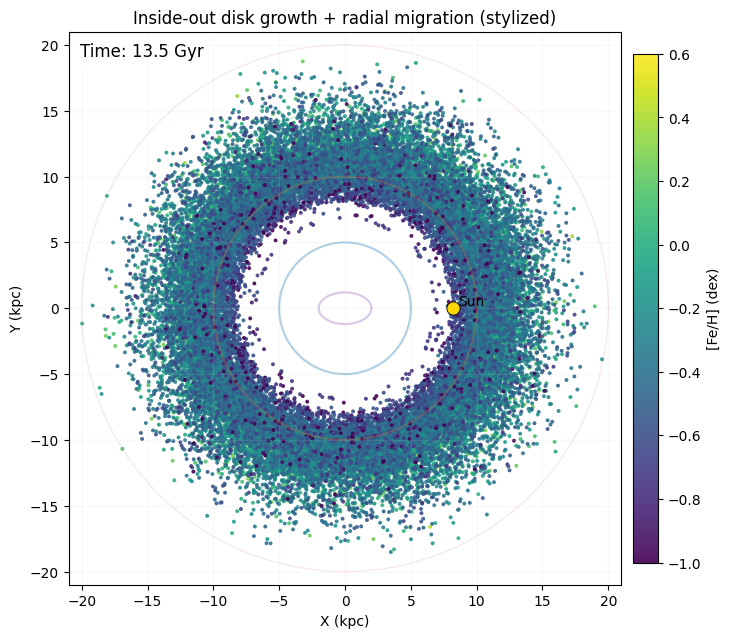

In [14]:
# =========================================================
# [ANIM_003|Cell ?] ANIM 1 — Toy inside-out radial migration (schematic)
#   - Source: processed APOGEE×Gaia ISM proxy (PROC/apogee_gaia_ism_proxy.csv)
#   - No memory reliance, no raw queries
#   - i18n + bootstrap paths + save_animation()
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) Load processed data
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(
        f"{NOTEBOOK}: missing processed source CSV:\n  {SRC_PATH}\n"
        "Expected columns at least: R_gal, feh (Z_gal optional)."
    )

df = pd.read_csv(SRC_PATH)

need = {"R_gal", "feh"}
miss = need - set(df.columns)
if miss:
    raise RuntimeError(
        f"{NOTEBOOK}: {SRC_PATH.name} missing required columns {miss}. "
        f"Have: {list(df.columns)[:40]}..."
    )

# ensure Z_gal exists (can be all zeros in proxy)
if "Z_gal" not in df.columns:
    df["Z_gal"] = 0.0

df = df.dropna(subset=["R_gal", "Z_gal", "feh"]).copy()
df = df[(df["R_gal"] >= 0.0) & (df["R_gal"] <= 20.0)].copy()
df = df[(df["feh"] >= -2.0) & (df["feh"] <= 1.0)].copy()

# keep runtime sane
N_MAX = 45_000
if len(df) > N_MAX:
    df = df.sample(N_MAX, random_state=1).reset_index(drop=True)

print("Loaded rows:", len(df), "| Source:", SRC_PATH.name)

# -----------------------------
# 1) i18n text
# -----------------------------
X_X   = L("x_kpc")
Y_Y   = L("y_kpc")
CB_FEH = L("feh")

TITLE = T("anim_inside_out_migration")

SUN_LBL = L("sun_label")
TIME_FMT = L("time_label_fmt")

# -----------------------------
# 2) Build toy migration vectors (stylized)
# -----------------------------
rng = np.random.default_rng(1)

R = df["R_gal"].to_numpy(dtype=float)
FEH = df["feh"].to_numpy(dtype=float)

# Random azimuth (we don't have true phi)
phi0 = rng.uniform(0, 2*np.pi, size=len(df))
x0 = R * np.cos(phi0)
y0 = R * np.sin(phi0)

# outward drift magnitude: metal-rich -> stronger outward migration (toy)
p5 = float(np.nanpercentile(FEH, 5))
p95 = float(np.nanpercentile(FEH, 95))
feh_norm = (FEH - p5) / (p95 - p5 + 1e-9)
feh_norm = np.clip(feh_norm, 0, 1)
dr = 0.3 + 3.7 * feh_norm  # kpc, chosen for clarity

# outward unit vector + mild tangential swirl
r0 = np.sqrt(x0**2 + y0**2) + 1e-9
ux = x0 / r0
uy = y0 / r0
tx, ty = -uy, ux

swirl = rng.normal(0.0, 0.35, size=len(df))
dx = dr * (0.90 * ux + swirl * tx)
dy = dr * (0.90 * uy + swirl * ty)

x1 = x0 + dx
y1 = y0 + dy

# clip softly to R<=20
r1 = np.sqrt(x1**2 + y1**2)
scale = np.where(r1 > 20.0, 20.0 / (r1 + 1e-9), 1.0)
x1 *= scale
y1 *= scale

# inside-out reveal order: smaller initial radius first
order = np.argsort(np.sqrt(x0**2 + y0**2))
x0, y0, x1, y1, FEH = x0[order], y0[order], x1[order], y1[order], FEH[order]

# -----------------------------
# 3) Animation parameters
# -----------------------------
T_START_GYR = 3.0
T_END_GYR   = 13.5
FRAMES = 120

N = len(x0)
base = int(np.ceil(N / FRAMES))
reveal_counts = np.clip((base * (0.7 + 0.6*np.linspace(0, 1, FRAMES))).astype(int), 50, None)

cum = np.cumsum(reveal_counts)
cum[-1] = N
cum = np.minimum(cum, N)

def lerp(a, b, t):
    return a + (b - a) * t

# -----------------------------
# 4) Plot setup
# -----------------------------
fig, ax = plt.subplots(figsize=(7.2, 7.2), constrained_layout=True)

theta = np.linspace(0, 2*np.pi, 600)
for rr, lw, a in [(5, 1.5, 0.35), (10, 1.2, 0.25), (15, 1.0, 0.18), (20, 0.8, 0.12)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), linewidth=lw, alpha=a)

# bulge (schematic ellipse)
bulge_a, bulge_b = 2.0, 1.2
ax.plot(bulge_a*np.cos(theta), bulge_b*np.sin(theta), linewidth=1.6, alpha=0.35)

# Sun marker
R_SUN = 8.2
ax.scatter([R_SUN], [0.0], s=90, c="gold", edgecolors="k", linewidths=0.6, zorder=6)
ax.text(R_SUN + 0.4, 0.2, SUN_LBL, fontsize=10)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-21, 21)
ax.set_ylim(-21, 21)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.set_title(TITLE)
ax.grid(alpha=0.12)

sc = ax.scatter([], [], s=8, c=[], cmap="viridis", vmin=-1.0, vmax=0.6, alpha=0.9, linewidths=0)

cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label(CB_FEH)

# time label (theme-aware)
if str(THEME).lower() == "dark":
    bbox = dict(boxstyle="round,pad=0.35", facecolor="#111111", alpha=0.85, edgecolor="none")
    time_color = "white"
else:
    bbox = dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85, edgecolor="none")
    time_color = "black"

time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    color=time_color,
    bbox=bbox
)

def update(frame):
    t = frame / (FRAMES - 1)
    t_gyr = lerp(T_START_GYR, T_END_GYR, t)
    time_txt.set_text(TIME_FMT.format(t=t_gyr))

    k = int(cum[frame])

    xx = lerp(x0[:k], x1[:k], t)
    yy = lerp(y0[:k], y1[:k], t)

    sc.set_offsets(np.c_[xx, yy])
    sc.set_array(FEH[:k])

    return sc, time_txt


# -----------------------------
# 5) Save (defaults pipeline)
# -----------------------------
anim = FuncAnimation(fig, update, frames=FRAMES, interval=1000 / FPS, blit=False)
save_animation(anim, anim_outpath("ISM_Migration_inside_out"))
save_last_frame(anim, "Figure_2")

plt.show()

*Figure 2.* Galaxy disk growth from inside out.

---

Loaded rows: 103380 | Source: apogee_gaia_ism_proxy.csv
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_inside_out_migration_stylized.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_inside_out_migration_stylized.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_3.png


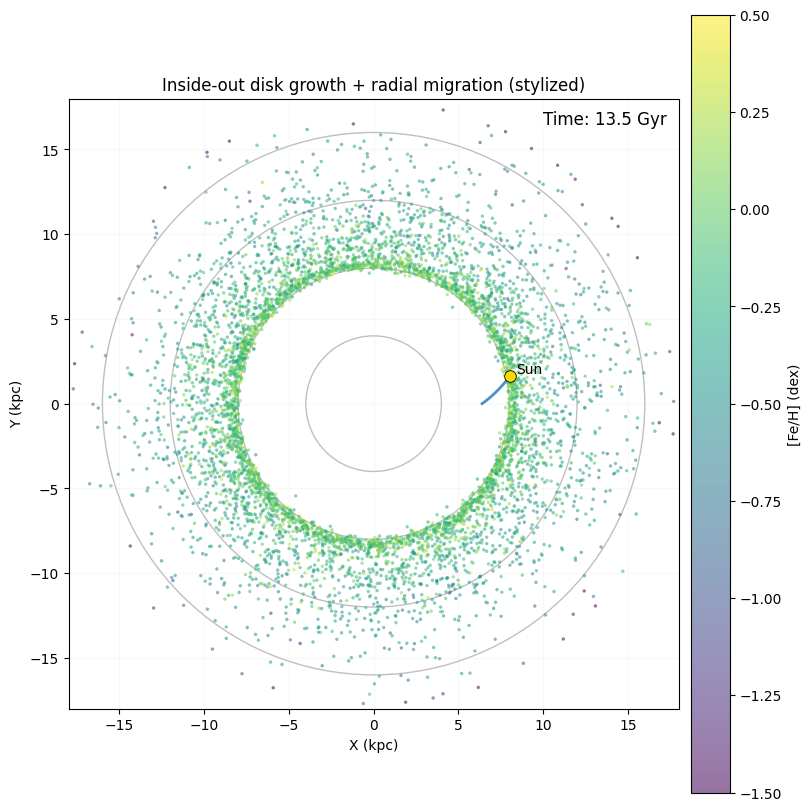

In [15]:
# =========================================================
# [ANIM_003|Cell ?] ANIM — Inside-out disk growth + radial migration (stylized)
#   - Source: PROC/apogee_gaia_ism_proxy.csv (R_gal, feh; Z_gal optional)
#   - Narrative animation: stars "form" over time, then drift rbirth -> R_now-like target
#   - Includes a migrating Sun marker with a short trail
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) Load processed data
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(f"{NOTEBOOK}: missing processed CSV:\n  {SRC_PATH}")

df = pd.read_csv(SRC_PATH).dropna(subset=["R_gal", "feh"]).copy()
if "Z_gal" not in df.columns:
    df["Z_gal"] = 0.0

df = df[(df["R_gal"] > 0.2) & (df["R_gal"] < 30.0)].copy()
df = df[(df["feh"] > -2.5) & (df["feh"] < 1.0)].copy()
print("Loaded rows:", len(df), "| Source:", SRC_PATH.name)

# -----------------------------
# 1) i18n text
# -----------------------------
X_X    = L("x_kpc")
Y_Y    = L("y_kpc")
CB_FEH = L("feh")

TITLE    = T("anim_inside_out_migration")
SUN_LBL  = L("sun_label")
TIME_FMT = L("time_label_fmt")

# -----------------------------
# 2) Settings (keep local but not duplicating bootstrap)
# -----------------------------
N_STARS = 6000
FRAMES = 160
R_MAX = 18.0

SUN_R_NOW = 8.2
T_START = 3.0
T_END   = 13.5

# -----------------------------
# 3) Simple chemistry + migration proxy (storytelling)
# -----------------------------
def feh_ism_rsun(age_gyr: np.ndarray) -> np.ndarray:
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age_gyr / tau) / np.log1p(13.5 / tau)
    return feh_now + (feh_early - feh_now) * x

def grad_dfeh_dr(age_gyr: np.ndarray) -> np.ndarray:
    g_today = -0.07
    g_early = -0.15
    return g_today + (g_early - g_today) * (age_gyr / 13.5)

def ease(x: np.ndarray) -> np.ndarray:
    return x*x*(3 - 2*x)

rng = np.random.default_rng(1)

samp = df.sample(min(N_STARS, len(df)), random_state=1).reset_index(drop=True)
R_now = np.clip(samp["R_gal"].to_numpy(float), 0.0, R_MAX)
feh   = samp["feh"].to_numpy(float)

phi_now = rng.uniform(0, 2*np.pi, size=len(samp))

# formation times (for reveal + drift)
t_form = rng.uniform(T_START, T_END, size=len(samp))
age_now = (T_END - t_form)

g = grad_dfeh_dr(age_now)
# guard against tiny gradients
g = np.where(np.abs(g) < 1e-3, np.sign(g) * 1e-3, g)

rb = SUN_R_NOW + (feh - feh_ism_rsun(age_now)) / g
rb = np.clip(rb, 0.0, R_MAX)

# outward bias for old stars (subtle; just to read "inside-out")
out_bias = 0.15 * (age_now / 13.5) * (R_MAX / 10.0)
R_target = np.clip(np.maximum(R_now, rb - 0.3) + out_bias, 0.0, R_MAX)

dR = (R_target - rb)
dphi = rng.normal(0.0, 0.35, size=len(samp)) * (age_now / 13.5)

# Sun (also migrates, schematic)
SUN_R_TARGET = SUN_R_NOW
SUN_R0 = np.clip(SUN_R_TARGET - 1.8, 0.0, R_MAX)
SUN_DPHI = 0.20
sun_phi0 = 0.0
sun_age = 4.6
sun_tform = T_END - sun_age

times = np.linspace(T_START, T_END, FRAMES)

# -----------------------------
# 4) Plot setup
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-R_MAX, R_MAX)
ax.set_ylim(-R_MAX, R_MAX)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.set_title(TITLE)
ax.grid(alpha=0.12)

for rr in [4, 8, 12, 16]:
    ax.add_patch(plt.Circle((0, 0), rr, fill=False, linewidth=1, alpha=0.25))

# stars (colored by [Fe/H])
sc = ax.scatter([], [], s=6, c=[], cmap="viridis", vmin=-1.5, vmax=0.5,
                alpha=0.55, linewidths=0)

cbar = fig.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label(CB_FEH)

# Sun marker + trail
sun_sc = ax.scatter([], [], s=70, marker="o", c="gold",
                    edgecolors="k", linewidths=0.6, zorder=5)
sun_tr, = ax.plot([], [], linewidth=2, alpha=0.8, zorder=4)
sun_lbl = ax.text(0, 0, "", fontsize=10, zorder=6)

# time label (theme-aware)
if str(THEME).lower() == "dark":
    bbox = dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.65, edgecolor="none")
    time_color = "white"
else:
    bbox = dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.75, edgecolor="none")
    time_color = "black"

time_txt = ax.text(
    0.98, 0.98, "", transform=ax.transAxes, ha="right", va="top",
    fontsize=12, color=time_color, bbox=bbox
)

# -----------------------------
# 5) Animation update
# -----------------------------
def update(i: int):
    t = times[i]
    active = t >= t_form

    if active.sum() == 0:
        sc.set_offsets(np.empty((0, 2)))
        sc.set_array(np.array([]))
    else:
        denom = np.where((T_END - t_form) <= 1e-6, 1.0, (T_END - t_form))
        prog = np.zeros_like(t_form)
        prog[active] = np.clip((t - t_form[active]) / denom[active], 0.0, 1.0)
        pp = ease(prog)

        R_t = rb + dR * pp
        phi_t = phi_now + dphi * pp

        x = R_t * np.cos(phi_t)
        y = R_t * np.sin(phi_t)

        sc.set_offsets(np.column_stack([x[active], y[active]]))
        sc.set_array(feh[active])

    # Sun
    if t < sun_tform:
        sun_pp = 0.0
    else:
        sun_pp = ease(np.clip((t - sun_tform) / (T_END - sun_tform), 0.0, 1.0))

    sun_R = SUN_R0 + (SUN_R_TARGET - SUN_R0) * sun_pp
    sun_phi = sun_phi0 + SUN_DPHI * sun_pp
    sun_x = sun_R * np.cos(sun_phi)
    sun_y = sun_R * np.sin(sun_phi)

    sun_sc.set_offsets([[sun_x, sun_y]])
    sun_lbl.set_position((sun_x + 0.35, sun_y + 0.15))
    sun_lbl.set_text(SUN_LBL)

    # Sun trail
    ntrail = max(2, int(60 * sun_pp))
    trail_pp = np.linspace(0, sun_pp, ntrail)
    trail_R = SUN_R0 + (SUN_R_TARGET - SUN_R0) * trail_pp
    trail_phi = sun_phi0 + SUN_DPHI * trail_pp
    sun_tr.set_data(trail_R * np.cos(trail_phi), trail_R * np.sin(trail_phi))

    time_txt.set_text(TIME_FMT.format(t=t))
    return sc, sun_sc, sun_tr, sun_lbl, time_txt


# -----------------------------
# 6) Save
# -----------------------------
anim = FuncAnimation(fig, update, frames=FRAMES, interval=1000 / FPS, blit=False)
save_animation(anim, anim_outpath("ISM_inside_out_migration_stylized"))
save_last_frame(anim, "Figure_3")

plt.show()

*Figure 3.* Galaxy disk growth from inside out + star radial migration.

---

### 1.3 Stars crossing spiral arms (density-wave model)

This animation illustrates the **density-wave interpretation** of spiral arms.

Key idea:
- spiral arms are **patterns**, not material structures;
- stars rotate faster than the pattern and
  periodically enter and exit spiral arms.

Implementation:
- synthetic logarithmic spiral arms;
- stars highlighted when within arm width;
- stars themselves follow smooth rotation + migration.

Result:
> Arms move through stars, not vice versa.

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_inside_out_migration_no_rotation.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_inside_out_migration_no_rotation.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_4.png


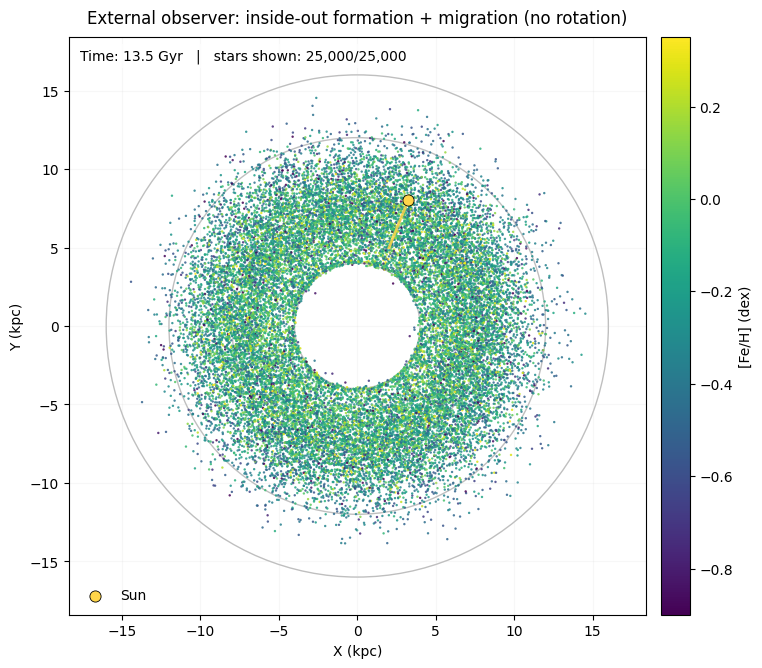

In [16]:
# ============================================================
# [ANIM_003|Cell ?] Inside-out formation + radial migration (no rotation)
# Source: PROC/apogee_gaia_ism_proxy.csv (R_gal, feh)
# Output: anim_outpath(...) + save_animation()
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) Load data (processed-only)
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(f"{NOTEBOOK}: missing processed CSV:\n  {SRC_PATH}")

df = pd.read_csv(SRC_PATH).dropna(subset=["R_gal", "feh"]).copy()

# -----------------------------
# 1) Controls (tune here)
# -----------------------------
R_MAX = 16.0
T_END_GYR = 13.5
T_MIN_GYR = 1.0

N = 25_000
FRAMES = 180

POINTS_PER_FRAME = 180
MIG_SIGMA_KPC = 4.0
MIG_MAX_KPC = 8.0
BIRTH_POWER = 1.2
BIRTH_SCATTER = 0.6

S = 3
ALPHA = 0.85
VMIN, VMAX = -0.9, 0.35

rng = np.random.default_rng(7)

# -----------------------------
# 2) i18n text
# -----------------------------
X_X    = L("x_kpc")
Y_Y    = L("y_kpc")
CB_FEH = L("feh")

TITLE   = T("anim_inside_out_migration_no_rotation")
SUN_LBL = L("sun_label")


# -----------------------------
# 3) Prepare "present-day anchors" from real data
# -----------------------------
df_use = df[(df["R_gal"] > 0.0) & (df["R_gal"] <= R_MAX)].copy()
if len(df_use) < 5000:
    print("Warning: small df_use after cuts:", len(df_use))

df_s = df_use.sample(min(N, len(df_use)), random_state=7).reset_index(drop=True)

R_now = df_s["R_gal"].to_numpy(dtype=float)
feh = df_s["feh"].to_numpy(dtype=float)
N = len(df_s)

# fixed per-star angle (top-view layout; NO rotation over time)
theta = rng.uniform(0, 2*np.pi, N)

# pick a representative "Sun" star (present-day near 8.2 kpc and ~solar metallicity)
sun_idx = int(np.argmin(np.abs(R_now - 8.2) + 0.15 * np.abs(feh - 0.0)))

# -----------------------------
# 4) Synthetic birth radii + birth times (inside-out) + migration
# -----------------------------
# 4.1 Birth radius (inner-heavy + weak correlation with R_now)
rb_raw = rng.beta(1.5, 4.5, size=N)            # inner-heavy
R_birth0 = 0.8 + rb_raw * (R_MAX - 0.8)        # [0.8..R_MAX]
R_birth = 0.55 * R_birth0 + 0.45 * np.clip(R_now - rng.normal(0.6, 0.8, N), 0.8, R_MAX)
R_birth = np.clip(R_birth, 0.8, R_MAX)

# 4.2 Birth time increases with radius (inside-out) + scatter
x = (R_birth - R_birth.min()) / max(R_birth.max() - R_birth.min(), 1e-9)
t_birth = T_MIN_GYR + (T_END_GYR - T_MIN_GYR) * (x ** BIRTH_POWER)
t_birth = np.clip(t_birth + rng.normal(0, BIRTH_SCATTER, N), T_MIN_GYR, T_END_GYR)

# 4.3 Age-dependent migration amplitude (older migrate more)
age = np.clip(T_END_GYR - t_birth, 0, T_END_GYR)
sigma = MIG_SIGMA_KPC * (age / T_END_GYR) ** 0.8
dR = np.clip(rng.normal(0, sigma, N), -MIG_MAX_KPC, MIG_MAX_KPC)

R_migr = np.clip(R_birth + dR, 0.8, R_MAX)

# Blend toward observed R_now so the snapshot looks plausible
R_target = np.clip(0.55 * R_migr + 0.45 * R_now, 0.8, R_MAX)

deltaR = (R_target - R_birth)

# (optional) force outward-only migration for Sun (illustrative)
deltaR[sun_idx] = abs(deltaR[sun_idx])
R_target[sun_idx] = max(R_target[sun_idx], R_birth[sun_idx] + 1e-3)

# -----------------------------
# 5) Theme-aware styling
# -----------------------------
dark = str(THEME).lower() == "dark"
BG = "#0b0f14" if dark else "white"
FG = "#e8e8e8" if dark else "black"
GRID_A = 0.10 if dark else 0.15

# -----------------------------
# 6) Figure
# -----------------------------
plt.close("all")
fig, ax = plt.subplots(figsize=(9.5, 7.5))
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)

for sp in ax.spines.values():
    sp.set_color(FG)

ax.tick_params(colors=FG)
ax.grid(alpha=GRID_A)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-R_MAX * 1.15, R_MAX * 1.15)
ax.set_ylim(-R_MAX * 1.15, R_MAX * 1.15)
ax.set_xlabel(X_X, color=FG)
ax.set_ylabel(Y_Y, color=FG)
ax.set_title(TITLE, color=FG, pad=10)

# radial rings
for rr in [4, 8, 12, 16]:
    ax.add_patch(plt.Circle((0, 0), rr, fill=False, lw=1.0, alpha=0.25, color=FG))

norm = mpl.colors.Normalize(vmin=VMIN, vmax=VMAX)
cmap = mpl.cm.viridis

sc = ax.scatter([], [], s=S, c=[], cmap=cmap, norm=norm, alpha=ALPHA, linewidths=0)

# Sun marker + path
sun_dot = ax.scatter([], [], s=65, c="#ffd54a", edgecolors="black",
                     linewidths=0.6, zorder=6, label=SUN_LBL)
sun_path, = ax.plot([], [], lw=2.0, alpha=0.85, color="#ffd54a", zorder=5)

time_txt = ax.text(
    0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left",
    color=("white" if dark else "black"),
    bbox=dict(facecolor=("black" if dark else "white"),
              alpha=0.65, boxstyle="round,pad=0.35", edgecolor="none")
)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.046, pad=0.02)
cbar.set_label(CB_FEH, color=FG)
cbar.ax.yaxis.set_tick_params(color=FG)
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color=FG)

ax.legend(loc="lower left", frameon=False, labelcolor=FG)

# -----------------------------
# 7) Animation logic
# -----------------------------
t_grid = np.linspace(T_MIN_GYR, T_END_GYR, FRAMES)
birth_order = np.argsort(t_birth)
sun_xy_hist = []

def init():
    sc.set_offsets(np.empty((0, 2)))
    sc.set_array(np.array([], dtype=float))
    sun_dot.set_offsets(np.array([[np.nan, np.nan]]))
    sun_path.set_data([], [])
    time_txt.set_text("")
    return (sc, sun_dot, sun_path, time_txt)

def update(i):
    t = t_grid[i]

    alive = np.where(t_birth <= t)[0]
    if len(alive) == 0:
        return (sc, sun_dot, sun_path, time_txt)

    n_cap = min(len(alive), (i + 1) * POINTS_PER_FRAME)
    idx = birth_order[:n_cap]
    idx = idx[t_birth[idx] <= t]
    if len(idx) == 0:
        return (sc, sun_dot, sun_path, time_txt)

    frac = np.clip((t - t_birth[idx]) / np.maximum((T_END_GYR - t_birth[idx]), 1e-6), 0, 1)
    R_t = R_birth[idx] + frac * deltaR[idx]

    x_t = R_t * np.cos(theta[idx])
    y_t = R_t * np.sin(theta[idx])

    sc.set_offsets(np.c_[x_t, y_t])
    sc.set_array(feh[idx])

    # Sun: always show once it is born
    if t >= t_birth[sun_idx]:
        frac_s = np.clip((t - t_birth[sun_idx]) / max(T_END_GYR - t_birth[sun_idx], 1e-6), 0, 1)
        R_s = R_birth[sun_idx] + frac_s * deltaR[sun_idx]
        sun_xy = (R_s * np.cos(theta[sun_idx]), R_s * np.sin(theta[sun_idx]))
    else:
        sun_xy = (np.nan, np.nan)

    sun_xy_hist.append(sun_xy)
    sun_dot.set_offsets(np.array([[sun_xy[0], sun_xy[1]]]))

    sx = [p[0] for p in sun_xy_hist if np.isfinite(p[0])]
    sy = [p[1] for p in sun_xy_hist if np.isfinite(p[1])]
    sun_path.set_data(sx, sy)

    time_txt.set_text(f"Time: {t:4.1f} Gyr   |   stars shown: {len(idx):,}/{N:,}")
    return (sc, sun_dot, sun_path, time_txt)


# -----------------------------
# 8) Save (our pipeline)
# -----------------------------
anim = FuncAnimation(fig, update, init_func=init, frames=FRAMES, interval=1000 / FPS, blit=True)
save_animation(anim, anim_outpath("ISM_inside_out_migration_no_rotation"))
save_last_frame(anim, "Figure_4")


plt.show()

*Figure 4.* Stars forming and moving from inside out (no rotation around Galaxy's core).

---

### 1.4. Inside-out formation + radial migration (1D schematic, no rotation)

This cell produces a **one-dimensional schematic animation** that illustrates the combined effects of **inside-out disk formation** and **radial migration**, deliberately **without azimuthal rotation**. The goal is conceptual clarity: by collapsing the disk to a single radial axis, the animation isolates how stars move from their birth radii to their present-day locations, without the visual complexity of full 2D kinematics.

Present-day radii (`R_gal`) are taken from the processed CSV (`PROC/apogee_gaia_ism_proxy.csv`) and used as **anchors** for the final state. Stellar birth times are drawn over 1.5–13.5 Gyr with a bias toward later formation, implementing an **inside-out narrative** in which the early disk is compact and the birth radius distribution broadens with time. Migration amplitudes are assigned with a controlled mix of outward and inward movers, clipped to a finite range and softly pulled back toward the observed present-day radii to maintain plausibility.

Each star appears only after its birth time and then interpolates smoothly from its birth radius to its final migrated radius. Stars are visually classified into **outward movers**, **inward movers**, and **nearly static objects**, using a small dead zone around ΔR ≈ 0 to reduce noise. A dedicated marker traces the **Sun**, which is forced to migrate outward in this schematic for reference and orientation.

The animation uses a minimalist 1D layout (radial axis only, with vertical jitter for separation) and highlights time evolution explicitly via a time label. Internationalization is applied only to plot-facing text (title, x-label, legend entries). The resulting animation is saved via the shared bootstrap helpers using `save_animation()`, ensuring consistency with the rest of the notebook outputs.

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_inside_out_migration_1d.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_inside_out_migration_1d.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_5.png


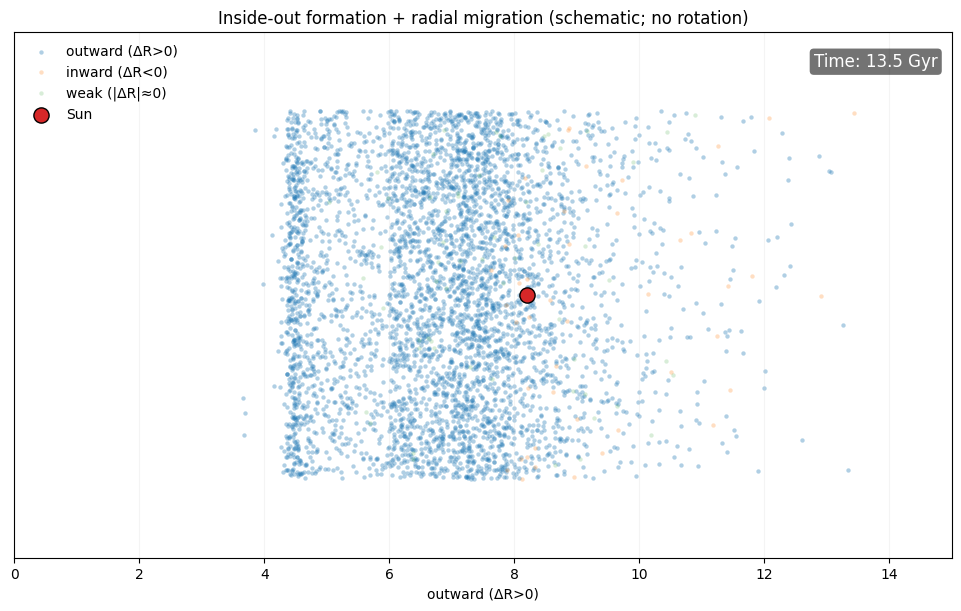

In [17]:
# =========================================================
# [ANIM_003|Cell ?] Inside-out formation + migration (1D schematic, no rotation)
#   Data: PROC/apogee_gaia_ism_proxy.csv (uses R_gal as present-day anchor)
#   Output: anim_outpath(...) via save_animation()
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) Load (CSV-only)
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(f"Missing source CSV: {SRC_PATH}")

src = pd.read_csv(SRC_PATH).dropna(subset=["R_gal"]).copy()
src = src[(src["R_gal"] >= 0.0) & (src["R_gal"] <= 20.0)].copy()

R_now_sample = src["R_gal"].to_numpy(dtype=float)
if len(R_now_sample) < 1000:
    raise RuntimeError(f"Too few R_gal samples in {SRC_PATH.name}: {len(R_now_sample)}")

# -----------------------------
# 1) Config (keep local knobs, but export uses global FPS)
# -----------------------------
N_STARS      = 4500
FRAMES       = 240

T_START_GYR  = 1.5
T_END_GYR    = 13.5

R_MIN, R_MAX = 0.0, 15.0

BIRTH_SIGMA0 = 2.0   # early disk compactness
BIRTH_SIGMA1 = 5.2   # late disk spread

P_OUTWARD    = 0.65
SIGMA_KPC    = 2.0
CLIP_KPC     = 6.0
EPS_STATIC   = 0.20

R_NOW_SUN    = 8.2
R_BIRTH_SUN  = 5.6

# Style
S_OUT, A_OUT = 10, 0.35
S_IN,  A_IN  = 10, 0.25
S_ST,  A_ST  = 10, 0.18
S_SUN        = 120

rng = np.random.default_rng(7)

# -----------------------------
# 2) Sample present-day anchors
# -----------------------------
R_now = rng.choice(R_now_sample[(R_now_sample >= R_MIN) & (R_now_sample <= R_MAX)],
                   size=N_STARS, replace=True)

# Birth times (inside-out narrative)
u = rng.random(N_STARS)
t_birth = T_START_GYR + (T_END_GYR - T_START_GYR) * (u ** 1.6)

# Time-dependent sigma → birth radii
sig = BIRTH_SIGMA0 + (BIRTH_SIGMA1 - BIRTH_SIGMA0) * ((t_birth - T_START_GYR) / (T_END_GYR - T_START_GYR))
sig = np.clip(sig, 0.8, 10.0)

R_birth = np.abs(rng.normal(loc=0.0, scale=sig, size=N_STARS))
R_birth = np.clip(R_birth, R_MIN, R_MAX)

# Preliminary ΔR to hit observed R_now
deltaR_raw = R_now - R_birth

# Enforce outward/inward fraction with clipped amplitude
n_out = int(round(P_OUTWARD * N_STARS))
sign = np.empty(N_STARS, dtype=np.int8)
sign[:n_out] = +1
sign[n_out:] = -1
rng.shuffle(sign)

amp = np.abs(deltaR_raw)
amp = 0.6 * amp + 0.4 * np.abs(rng.normal(0.0, SIGMA_KPC, size=N_STARS))
amp = np.clip(amp, 0.0, CLIP_KPC)

deltaR = sign * amp

# End radius + soft pull back toward observed R_now
R_end = np.clip(R_birth + deltaR, R_MIN, R_MAX)
pull = 0.55
R_end = np.clip((1 - pull) * R_end + pull * R_now, R_MIN, R_MAX)

deltaR = np.clip(R_end - R_birth, -CLIP_KPC, CLIP_KPC)

def interp_R(t):
    frac = (t - t_birth) / (T_END_GYR - t_birth)
    frac = np.clip(frac, 0.0, 1.0)
    return R_birth + frac * deltaR

# Sun (always outward)
sun_deltaR = R_NOW_SUN - R_BIRTH_SUN
def sun_R(t):
    frac = (t - T_START_GYR) / (T_END_GYR - T_START_GYR)
    frac = np.clip(frac, 0.0, 1.0)
    return R_BIRTH_SUN + frac * sun_deltaR

# -----------------------------
# 3) i18n strings
# -----------------------------
TITLE   = T("inside_out_migration_1d")
XLABEL  = L("inside_out_migration_1d_xlabel")

LEG_OUT = L("legend_outward")
LEG_IN  = L("legend_inward")
LEG_ST  = L("legend_weak")
LEG_SUN = L("legend_sun")

# -----------------------------
# 4) Figure
# -----------------------------
fig, ax = plt.subplots(figsize=(9.5, 6.0), constrained_layout=True)
ax.set_xlim(R_MIN, R_MAX)
ax.set_ylim(-1.0, 1.0)
ax.set_yticks([])
ax.set_xlabel(XLABEL)
ax.set_title(TITLE)
ax.grid(alpha=0.2)

y_jit = (rng.random(N_STARS) - 0.5) * 1.4

sc_out = ax.scatter([], [], s=S_OUT, alpha=A_OUT, linewidths=0, label=LEG_OUT)
sc_in  = ax.scatter([], [], s=S_IN,  alpha=A_IN,  linewidths=0, label=LEG_IN)
sc_st  = ax.scatter([], [], s=S_ST,  alpha=A_ST,  linewidths=0, label=LEG_ST)
sun_sc = ax.scatter([], [], s=S_SUN, marker="o", edgecolors="k", linewidths=1.0, label=LEG_SUN)

ax.legend(frameon=False, loc="upper left")

time_txt = ax.text(
    0.985, 0.96, "", transform=ax.transAxes,
    ha="right", va="top", fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.55, edgecolor="none"),
    color="white"
)

times = np.linspace(T_START_GYR, T_END_GYR, FRAMES)

def init():
    empty = np.empty((0, 2))
    sc_out.set_offsets(empty)
    sc_in.set_offsets(empty)
    sc_st.set_offsets(empty)
    sun_sc.set_offsets(empty)
    time_txt.set_text("")
    return sc_out, sc_in, sc_st, sun_sc, time_txt

def update(i):
    t = times[i]
    born = t >= t_birth
    if not np.any(born):
        return sc_out, sc_in, sc_st, sun_sc, time_txt

    x = np.clip(interp_R(t), R_MIN, R_MAX)
    dR = deltaR

    out = born & (dR >  EPS_STATIC)
    inn = born & (dR < -EPS_STATIC)
    sta = born & (~out) & (~inn)

    sc_out.set_offsets(np.c_[x[out], y_jit[out]])
    sc_in.set_offsets( np.c_[x[inn], y_jit[inn]])
    sc_st.set_offsets( np.c_[x[sta], y_jit[sta]])

    sx = float(np.clip(sun_R(t), R_MIN, R_MAX))
    sun_sc.set_offsets(np.array([[sx, 0.0]]))

    time_txt.set_text(f"Time: {t:4.1f} Gyr")
    return sc_out, sc_in, sc_st, sun_sc, time_txt


ani = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=True, interval=1000/FPS)
save_animation(ani, anim_outpath("inside_out_migration_1d"))
save_last_frame(ani, "Figure_5")


plt.show()

*Figure 5.* Inside out migration 1D

---

### 1.5. Face-on disk: differential rotation + radial migration (illustrative)

This cell generates a **face-on (top-down) animation of a Milky Way–like stellar disk** that combines **differential rotation** with **radial migration** in a deliberately illustrative (“physics-ish”) manner. The input comes from the processed CSV `apogee_gaia_ism_proxy.csv`, which is used to anchor the **present-day radial distribution and metallicity** of stars; all subsequent dynamics are schematic and intended for visualization and intuition rather than detailed dynamical accuracy.

Stellar motion is modeled as follows: stars rotate around the Galactic center with an angular speed inversely proportional to radius (flat rotation curve assumption), while simultaneously undergoing a smooth radial displacement from their initial radius. Migration amplitudes are drawn from a clipped distribution with a mild metallicity-dependent bias, and the time evolution of migration is controlled by a smooth ease-in–ease-out function. Both rotation and migration accumulate from 3 Gyr to 13.5 Gyr, producing a continuously evolving disk morphology.

An optional **Milky Way background image** can be overlaid beneath the scatter plot to provide visual context. Concentric guide rings mark characteristic radii, including the solar circle. The **Sun** is treated as a special tracer: it appears only after a specified birth time, follows its own rotating and migrating track, and during the final hold phase its **purely radial displacement ΔR** is highlighted with a straight connector and an explanatory callout. This separation of azimuthal motion from radial migration makes the Sun’s migration visually explicit.

*During the simulated time span of ~10.5 Gyr, the Sun completes roughly 45 revolutions around the Galactic center, while slowly migrating outward together with the stellar disk.*

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_Differential_rotation_radial_migration_bg.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_Differential_rotation_radial_migration_bg.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_6.png


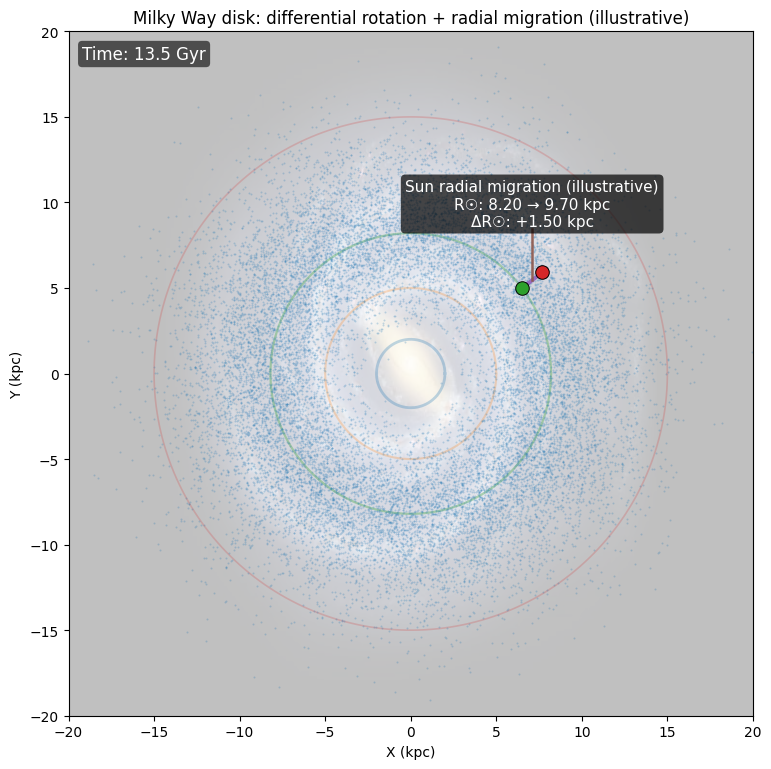

In [18]:
# =========================================================
# [ANIM_003|Cell X] Face-on disk: differential rotation + radial migration (illustrative)
#   Background MW image (optional) + Sun ΔR callout on final hold
#   Source: apogee_gaia_ism_proxy.csv (processed, CSV-only)
#   Output: MP4 via save_animation() into ANIM_DIR
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import AnchoredText

# -----------------------------
# 0) i18n
# -----------------------------
X_X    = L("x_kpc")
Y_Y    = L("y_kpc")
CB_FEH = L("feh")

TITLE = T("faceon_rotation_migration")

SUN_LABEL = L("sun")
TIME_FMT  = L("time_fmt")

CALLOUT_HDR  = L("sun_callout_hdr")
CALLOUT_BODY = L("sun_callout_body")


# -----------------------------
# 1) Input + optional background
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(
        f"{NOTEBOOK} face-on cell: missing processed CSV:\n  {SRC_PATH}\n"
        "Expected columns at least: R_gal, feh."
    )

BG_IMG_PATH = TOPIC_ROOT / "assets" / "nasa-milky-way-galaxy.jpg"
BG_ALPHA = 0.25
BG_ZORDER = -50

df = pd.read_csv(SRC_PATH).dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

# -----------------------------
# 2) Sample anchors
# -----------------------------
N = min(len(df), 20_000)
rng = np.random.default_rng(7)

samp = df.sample(N, random_state=7).reset_index(drop=True)
R0 = samp["R_gal"].to_numpy(float)
feh = samp["feh"].to_numpy(float)
phi0 = rng.uniform(0, 2*np.pi, size=N)

# -----------------------------
# 3) "Physics-ish" parametrization
# -----------------------------
T_START_GYR = 3.0
T_END_GYR   = 13.5

V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR

Omega = V_KPC_PER_GYR / np.clip(R0, 0.8, None)

sigma_kpc = 2.0
dR_end = rng.normal(0.0, sigma_kpc, size=N)
dR_end = np.clip(dR_end, -5.0, 5.0)
dR_end += 0.6 * np.tanh(feh)  # illustrative bias
dR_end = np.clip(dR_end, -5.0, 5.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

# -----------------------------
# 4) Sun track (appears late) + final callout (hold)
# -----------------------------
SUN_BIRTH_GYR = 9.0
Rsun0 = 8.2
phi_sun0 = np.deg2rad(20.0)
Omega_sun = V_KPC_PER_GYR / Rsun0
dR_sun_end = 1.5

# -----------------------------
# 5) Animation timing
# -----------------------------
DURATION_SEC = 30.0
FPS_LOCAL = 30  # this cell is explicitly 30 fps
BASE_FRAMES = int(DURATION_SEC * FPS_LOCAL)

HOLD_LAST_SEC = 3.0
HOLD_FRAMES = int(HOLD_LAST_SEC * FPS_LOCAL)

FRAMES = BASE_FRAMES + HOLD_FRAMES

R_MAX = 20.0
lim = R_MAX

ROTATION_SCALE = 0.35
Omega_eff = Omega * ROTATION_SCALE
Omega_sun_eff = Omega_sun * ROTATION_SCALE

# precompute final-frame Sun radial-only annotation at final azimuth
dt_total = (T_END_GYR - T_START_GYR)
phi_sun_final = phi_sun0 + Omega_sun_eff * dt_total

Rsun_birth = Rsun0
Rsun_final = Rsun0 + dR_sun_end
delta_R = Rsun_final - Rsun_birth

x_birth = Rsun_birth * np.cos(phi_sun_final)
y_birth = Rsun_birth * np.sin(phi_sun_final)
x_final = Rsun_final * np.cos(phi_sun_final)
y_final = Rsun_final * np.sin(phi_sun_final)

# -----------------------------
# 6) Figure
# -----------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.set_title(TITLE)

# optional MW background image
if BG_IMG_PATH.exists():
    bg = plt.imread(BG_IMG_PATH)
    ax.imshow(
        bg,
        extent=(-lim, lim, -lim, lim),
        origin="lower",
        alpha=BG_ALPHA,
        zorder=BG_ZORDER
    )
else:
    print("Background image not found:", BG_IMG_PATH)

# ring guides
theta = np.linspace(0, 2*np.pi, 512)
for rr, lw, a in [(2.0, 2.0, 0.28), (5.0, 1.5, 0.24), (8.2, 1.6, 0.32), (15.0, 1.2, 0.20)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, zorder=0)

# stars
PT_SIZE = 2.0
PT_ALPHA = 0.25
sc = ax.scatter([], [], s=PT_SIZE, alpha=PT_ALPHA, linewidths=0, zorder=2)

# Sun (moving)
sun_sc = ax.scatter([], [], s=80, marker="o",
                    edgecolors="k", linewidths=0.6, zorder=6)

# time label
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# final-frame extras
sun_birth_sc = ax.scatter([], [], s=95, marker="o",
                          edgecolors="k", linewidths=0.7, zorder=9)
sun_final_sc = ax.scatter([], [], s=95, marker="o",
                          edgecolors="k", linewidths=0.7, zorder=9)

sun_connector, = ax.plot([], [], lw=2.8, alpha=0.95, zorder=8)

callout_line, = ax.plot([], [], lw=1.8, alpha=0.9, zorder=8)
callout_txt = ax.text(
    np.nan, np.nan, "",
    ha="center", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.70, edgecolor="none"),
    color="white",
    zorder=10
)

# -----------------------------
# 7) Animation
# -----------------------------
def init():
    sc.set_offsets(np.zeros((0, 2)))
    sun_sc.set_offsets(np.array([[np.nan, np.nan]]))

    sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_connector.set_data([], [])

    callout_line.set_data([], [])
    callout_txt.set_position((np.nan, np.nan))
    callout_txt.set_text("")
    time_txt.set_text("")
    return []

def update(i):
    # Freeze last frame for HOLD_FRAMES
    if i >= BASE_FRAMES - 1:
        u = 1.0
    else:
        u = i / (BASE_FRAMES - 1)

    e = ease_in_out(u)

    t_gyr = T_START_GYR + (T_END_GYR - T_START_GYR) * u
    dt = (t_gyr - T_START_GYR)

    # stars
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega_eff * dt
    x = R * np.cos(phi)
    y = R * np.sin(phi)
    sc.set_offsets(np.column_stack([x, y]))

    time_txt.set_text(TIME_FMT.format(t=t_gyr))

    # Sun appears only after SUN_BIRTH_GYR
    if t_gyr < SUN_BIRTH_GYR:
        sun_sc.set_offsets(np.array([[np.nan, np.nan]]))
        show_sun = False
    else:
        show_sun = True
        R_sun = Rsun0 + dR_sun_end * e
        phi_sun = phi_sun0 + Omega_sun_eff * dt
        x_sun = R_sun * np.cos(phi_sun)
        y_sun = R_sun * np.sin(phi_sun)
        sun_sc.set_offsets(np.array([[x_sun, y_sun]]))

    # Final hold: show radial-only ΔR annotation (straight line at final azimuth)
    if (i >= BASE_FRAMES - 1) and show_sun:
        sun_birth_sc.set_offsets(np.array([[x_birth, y_birth]]))
        sun_final_sc.set_offsets(np.array([[x_final, y_final]]))
        sun_connector.set_data([x_birth, x_final], [y_birth, y_final])

        mx, my = 0.5*(x_birth + x_final), 0.5*(y_birth + y_final)
        LIFT = 3.0
        tx, ty = mx, my + LIFT
        callout_line.set_data([mx, tx], [my, ty])

        callout_txt.set_position((tx, ty))
        callout_txt.set_text(
            CALLOUT_HDR + "\n" + CALLOUT_BODY.format(rb=Rsun_birth, rf=Rsun_final, dr=delta_R)
        )
    else:
        sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_connector.set_data([], [])
        callout_line.set_data([], [])
        callout_txt.set_position((np.nan, np.nan))
        callout_txt.set_text("")

    return []


# -----------------------------
# 8) Save (two lines)
# -----------------------------
ani = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=True, interval=1000/FPS)
save_animation(ani, anim_outpath("Differential_rotation_radial_migration_bg"))
save_last_frame(ani, "Figure_6")


plt.show()

*Figure 6.*  Sun migration in a Galaxy

---

### 1.6. Spiral density waves and stars rotating in a galaxy

The goal of this animation is to visualize a key idea of galactic dynamics:

Spiral arms are not rigid structures made of the same stars.
They are density waves through which stars continuously pass.

What the viewer sees
- Spiral arms (density waves) are shown as semi-transparent gray structures.
They rotate as a coherent pattern with a nearly constant pattern speed.
- Stars (blue points) represent stellar material in the disk.

They follow differential rotation and radial migration.

As stars move through the disk, they:
- enter a spiral arm,
- experience a temporary local overdensity,
- and then leave the arm again.

To make this process visible, stars are rendered slightly brighter or larger while they are inside a spiral arm and return to their normal appearance outside it.

Physical interpretation

Relative motion between stars and spiral arms

Each star has its own angular velocity,
$$ \Omega_\star(R) = \frac{V(R)}{R},$$
while the spiral pattern rotates with a nearly constant angular speed,
$\Omega_p$.

As a result:
- In the inner disk, stars typically rotate faster than the spiral pattern and overtake the arms.
- In the outer disk, stars rotate more slowly and are overtaken by the arms.

This relative motion causes stars to enter and exit spiral arms repeatedly over time.

Why spiral arms do not wind up

The animation illustrates why spiral arms do not get wound tighter and tighter by differential rotation.
- The arms themselves are patterns, not collections of permanently bound stars.
- Stars move in and out of these patterns, similar to cars moving through a traffic jam:
the congestion persists, even though individual cars continuously change.

What this visualization demonstrates
- Spiral arms can remain long-lived despite differential rotation.
- Stars are not permanently attached to spiral arms.
- A stellar system (including the Sun) may spend only part of its life inside a spiral arm.
- Local overdensities in spiral arms naturally enhance star formation without trapping stars.

This animation provides an intuitive, visual explanation of spiral density waves and their role in shaping the structure and evolution of disk galaxies.


#### Stars crossing spiral arms (density-wave model)

This cell generates a face-on (top-down) animation of a Milky Way–like disk in which stars move through spiral arms modeled as a rotating density-wave pattern. The input comes from the processed CSV `PROC/apogee_gaia_ism_proxy.csv`, which is used only as a proxy for the stellar radial distribution and metallicity. The visualization is intentionally schematic and meant to build intuition rather than represent a fully physical simulation.

The model combines three effects: (1) differential rotation of stars in the disk, (2) a spiral pattern rotating more slowly than the stars (density-wave picture), and (3) a smooth radial migration term. Rotation and migration accumulate from a reference formation time of 3 Gyr, while the animation itself starts at 10 Gyr and runs to 13.5 Gyr. This choice avoids showing an unrealistically empty early disk and focuses the viewer on the mature spiral structure.

Spiral arms are represented by a large synthetic “gas” component distributed along logarithmic spirals with a given pitch angle and width, plus a small inter-arm population for realism. At each frame, stars are classified as being inside or outside an arm by measuring their phase distance to the nearest arm at the same radius. Stars inside arms are highlighted with larger size and higher opacity, producing the visual effect of stars continuously entering and leaving spiral arms as they orbit.

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_stars_cross_spiral_arms.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_stars_cross_spiral_arms.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_7.png


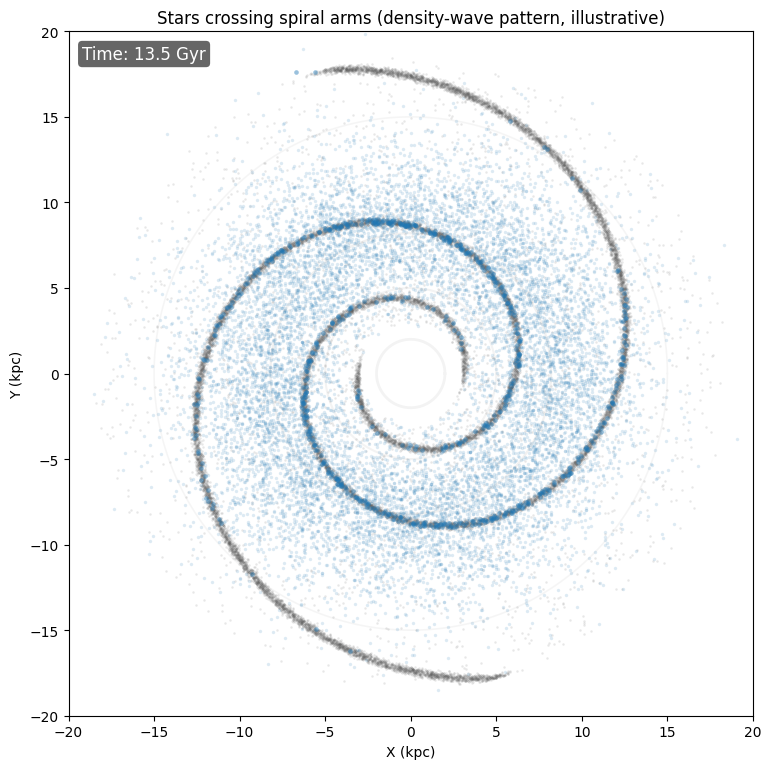

In [19]:
# =========================================================
# [ANIM_003|Cell X] Face-on disk: stars enter/exit spiral arms (density-wave model)
#   Display starts at 10 Gyr (but kinematics accumulate from 3 Gyr)
#   Source: PROC/apogee_gaia_ism_proxy.csv (CSV-only)
#   Output: via bootstrap save_animation() into ANIM_DIR
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) i18n
# -----------------------------
X_X = L("x_kpc")
Y_Y = L("y_kpc")

TITLE = T("spiral_arms_crossing")
TIME_FMT = L("time_fmt")

# -----------------------------
# 1) Input CSV (processed-only)
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(
        f"{NOTEBOOK} spiral-arms cell: missing processed CSV:\n  {SRC_PATH}\n"
        "Expected columns at least: R_gal, feh."
    )

df = pd.read_csv(SRC_PATH).dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

# ---------------------------------------------------------
# 2) Stellar component (real data proxy)
# ---------------------------------------------------------
N_STARS = min(len(df), 12_000)
rng = np.random.default_rng(7)

samp = df.sample(N_STARS, random_state=7).reset_index(drop=True)
R0   = samp["R_gal"].to_numpy(float)
feh  = samp["feh"].to_numpy(float)
phi0 = rng.uniform(0, 2*np.pi, size=N_STARS)

# ---------------------------------------------------------
# 3) Spiral density-wave tracers (synthetic “gas”)
# ---------------------------------------------------------
N_GAS = 22_000
N_ARMS = 2
PITCH_DEG = 12.5
ARM_WIDTH_KPC = 0.55
R_GAS_MIN, R_GAS_MAX = 3.0, 18.5

pitch = np.deg2rad(PITCH_DEG)
b = 1.0 / np.tan(pitch)

R_gas0 = rng.uniform(R_GAS_MIN, R_GAS_MAX, size=N_GAS)
arm_id = rng.integers(0, N_ARMS, size=N_GAS)

phi_arm0 = arm_id * (2*np.pi / N_ARMS) + b * np.log(R_gas0)
phi_scatter = rng.normal(0.0, ARM_WIDTH_KPC / np.clip(R_gas0, 1.0, None), size=N_GAS)
phi_gas0 = phi_arm0 + phi_scatter

# add a small inter-arm component for realism
F_INTERARM = 0.12
n_inter = int(F_INTERARM * N_GAS)
if n_inter > 0:
    R_int = rng.uniform(R_GAS_MIN, R_GAS_MAX, size=n_inter)
    phi_int = rng.uniform(0, 2*np.pi, size=n_inter)
    R_gas0 = np.concatenate([R_gas0, R_int])
    phi_gas0 = np.concatenate([phi_gas0, phi_int])

# ---------------------------------------------------------
# 4) Kinematics
# ---------------------------------------------------------
T_FORM_START_GYR = 3.0   # evolution reference (rotation+migration accumulate from here)
T_ANIM_START_GYR = 10.0  # first displayed frame
T_END_GYR        = 13.5

V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR

Omega_star = V_KPC_PER_GYR / np.clip(R0, 0.8, None)

sigma_kpc = 2.0
dR_end = rng.normal(0.0, sigma_kpc, size=N_STARS)
dR_end = np.clip(dR_end, -5.0, 5.0)
dR_end += 0.6 * np.tanh(feh)  # illustrative bias
dR_end = np.clip(dR_end, -5.0, 5.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

ROTATION_SCALE = 0.22
Omega_star_eff = Omega_star * ROTATION_SCALE

PATTERN_KMS_PER_KPC = 25.0
Omega_p = PATTERN_KMS_PER_KPC * KMS_TO_KPC_PER_GYR
Omega_p_eff = Omega_p * ROTATION_SCALE * 0.5  # arms rotate slower

# ---------------------------------------------------------
# 5) “Stars in arms” highlighting model
# ---------------------------------------------------------
ARM_HIGHLIGHT_KPC = 0.7

def wrap_pi(angle):
    return (angle + np.pi) % (2*np.pi) - np.pi

# ---------------------------------------------------------
# 6) Animation settings
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS_LOCAL = 30
FRAMES = int(DURATION_SEC * FPS_LOCAL)

R_MAX = 20.0
lim = R_MAX

STAR_SIZE_BASE  = 6.0
STAR_SIZE_IN    = 11.0
STAR_ALPHA_BASE = 0.15
STAR_ALPHA_IN   = 0.45

GAS_SIZE  = 3.0
GAS_ALPHA = 0.14
# keep neutral; theme is already applied globally by bootstrap
GAS_COLOR = "0.55" if str(THEME).lower() == "dark" else "0.35"
RING_COLOR = "0.25" if str(THEME).lower() == "dark" else "0.55"

# ---------------------------------------------------------
# 7) Figure
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.set_title(TITLE)

theta = np.linspace(0, 2*np.pi, 512)
for rr, lw, a in [(2.0, 2.0, 0.10), (5.0, 1.5, 0.10), (8.2, 1.6, 0.12), (15.0, 1.2, 0.08)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, color=RING_COLOR, zorder=0)

gas_sc = ax.scatter([], [], s=GAS_SIZE, alpha=GAS_ALPHA, linewidths=0, color=GAS_COLOR, zorder=1)

star_out_sc = ax.scatter([], [], s=STAR_SIZE_BASE, alpha=STAR_ALPHA_BASE,
                         linewidths=0, color="tab:blue", zorder=3)

star_in_sc  = ax.scatter([], [], s=STAR_SIZE_IN, alpha=STAR_ALPHA_IN,
                         linewidths=0, color="tab:blue", zorder=4)

time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# ---------------------------------------------------------
# 8) Animation
# ---------------------------------------------------------
def init():
    gas_sc.set_offsets(np.zeros((0, 2)))
    star_out_sc.set_offsets(np.zeros((0, 2)))
    star_in_sc.set_offsets(np.zeros((0, 2)))
    time_txt.set_text("")
    return []

def update(i):
    # Display time goes from 10 -> 13.5 Gyr
    u_anim = i / (FRAMES - 1)
    t_gyr = T_ANIM_START_GYR + (T_END_GYR - T_ANIM_START_GYR) * u_anim

    # Evolution time fraction (for migration easing) goes 3 -> 13.5
    u_evo = (t_gyr - T_FORM_START_GYR) / (T_END_GYR - T_FORM_START_GYR)
    u_evo = np.clip(u_evo, 0.0, 1.0)
    e = ease_in_out(u_evo)

    # Rotation accumulates from formation reference
    dt = (t_gyr - T_FORM_START_GYR)

    # --- gas pattern (arms) ---
    phi_g = phi_gas0 + Omega_p_eff * dt
    xg = R_gas0 * np.cos(phi_g)
    yg = R_gas0 * np.sin(phi_g)
    gas_sc.set_offsets(np.column_stack([xg, yg]))

    # --- stars: rotation + migration ---
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega_star_eff * dt
    xs = R * np.cos(phi)
    ys = R * np.sin(phi)

    # classify “in arm” by closest arm distance at given R
    arm_phase = (np.arange(N_ARMS)[:, None] * (2*np.pi / N_ARMS)) + b * np.log(R)[None, :] + (Omega_p_eff * dt)
    dphi = wrap_pi(phi[None, :] - arm_phase)
    dphi_min = np.abs(dphi).min(axis=0)
    dist_kpc = R * dphi_min
    in_arm = dist_kpc < ARM_HIGHLIGHT_KPC

    out_xy = np.column_stack([xs[~in_arm], ys[~in_arm]])
    in_xy  = np.column_stack([xs[in_arm],  ys[in_arm]])

    star_out_sc.set_offsets(out_xy if len(out_xy) else np.zeros((0, 2)))
    star_in_sc.set_offsets(in_xy if len(in_xy) else np.zeros((0, 2)))

    time_txt.set_text(TIME_FMT.format(t=t_gyr))
    return []


# ---------------------------------------------------------
# 9) Save (two lines)
# ---------------------------------------------------------
anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False)
save_animation(anim, anim_base("stars_cross_spiral_arms"))
save_last_frame(anim, "Figure_7")


plt.show()

*Figure 7.* Density waves (spiral arms) in the Galaxy

---

### 1.7. Face-on disk: longitudinal traveling wave (actual displacement)

This cell creates a face-on (top-down) animation of a stellar disk in which stars undergo a **longitudinal traveling wave** implemented as an **actual tangential displacement** (a perturbation in azimuth, Δφ). The base star sample is taken from the processed CSV `PROC/apogee_gaia_ism_proxy.csv`, using `R_gal` as a present-day radial anchor and `[Fe/H]` only to introduce a mild illustrative bias in the small radial-migration term.

The baseline motion is intentionally subtle: stars rotate with an angular speed Ω(R) scaled down to keep motion visually readable, and they experience a small, smooth radial migration from `R0` to `R0 + ΔR` using an ease-in–ease-out envelope. On top of this, a wave pattern is applied by advecting each star’s azimuth: the phase variable depends on azimuth and radius via `s = M·φ + β·ln(R/Rref)`, producing spiral-like crests that propagate through the disk.

A key feature is that the wave is **back-and-forth** rather than unidirectional. The propagation direction flips every half-period (controlled by `W_PERIOD_SEC`), so the crests alternately move “forward” and “backward” through the stellar distribution. This is meant to emphasize the visual idea of a pattern moving through matter, while remaining purely illustrative rather than physically self-consistent.

The figure includes simple ring guides and an on-plot time label showing the current simulation time and the wave direction. The animation is rendered with `FuncAnimation` and saved as an MP4 to `ANIM_DIR` via the shared bootstrap `save_animation()` and `anim_outpath()` helpers.

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_longitudinal_wave_displacement_backforth.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_longitudinal_wave_displacement_backforth.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_8.png


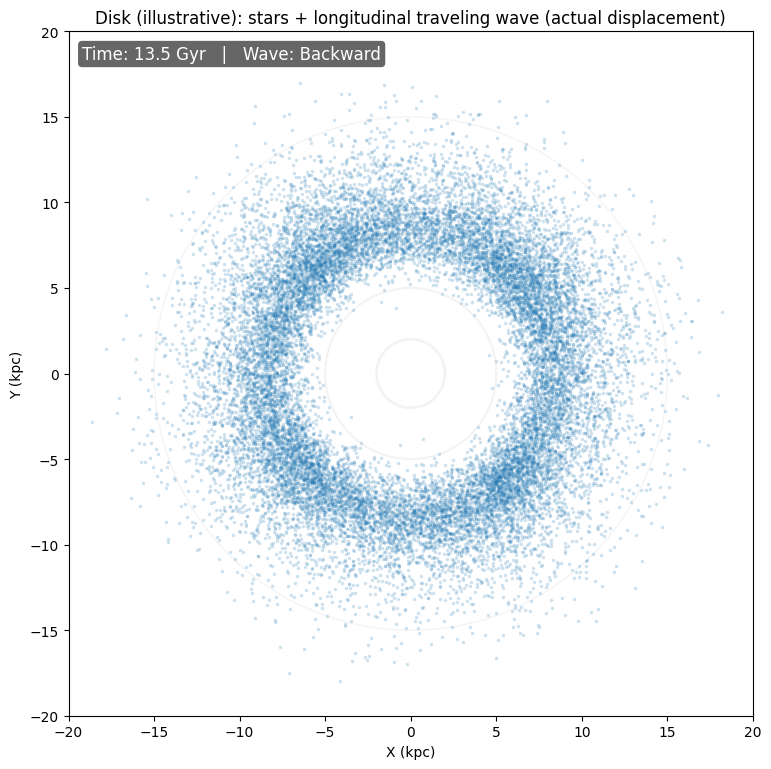

In [20]:
# =========================================================
# [ANIM_003|Cell X] Face-on disk: longitudinal traveling wave (actual displacement)
#   Back-and-forth wave that advects stars tangentially (Δphi),
#   so crests move through matter (illustrative).
#   Source: PROC/apogee_gaia_ism_proxy.csv (CSV-only)
#   Output: via bootstrap save_animation() into ANIM_DIR
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) i18n
# -----------------------------
X_X = L("x_kpc")
Y_Y = L("y_kpc")

TITLE = T("longitudinal_wave_title")
TIME_FMT = T("time_fmt")  # expects "Time: {t:4.1f} Gyr"

WAVE_FWD = L("wave_forward")   # default in YAML: "forward"
WAVE_BWD = L("wave_backward")  # default in YAML: "backward"

# -----------------------------
# 0) Input CSV (processed-only)
# -----------------------------
SRC_PATH = PROC / "apogee_gaia_ism_proxy.csv"
if not SRC_PATH.exists():
    raise FileNotFoundError(
        f"{NOTEBOOK} longitudinal-wave cell: missing processed CSV:\n  {SRC_PATH}\n"
        "Expected columns at least: R_gal, feh."
    )

df = pd.read_csv(SRC_PATH).dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

# ---------------------------------------------------------
# 1) Stellar sample (<=20k)
# ---------------------------------------------------------
N = min(len(df), 20_000)
rng = np.random.default_rng(7)

samp = df.sample(N, random_state=7).reset_index(drop=True)
R0   = samp["R_gal"].to_numpy(float)
feh  = samp["feh"].to_numpy(float)
phi0 = rng.uniform(0, 2*np.pi, size=N)

# ---------------------------------------------------------
# 2) Baseline motions (subtle)
# ---------------------------------------------------------
T_START_GYR = 7.0
T_END_GYR   = 13.5

V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR

ROTATION_SCALE = 0.18
Omega = (V_KPC_PER_GYR / np.clip(R0, 0.8, None)) * ROTATION_SCALE

# mild migration (small)
sigma_kpc = 1.0
dR_end = rng.normal(0.0, sigma_kpc, size=N)
dR_end = np.clip(dR_end, -3.0, 3.0)
dR_end += 0.25 * np.tanh(feh)
dR_end = np.clip(dR_end, -3.0, 3.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

# ---------------------------------------------------------
# 3) Longitudinal traveling wave as actual advection in phi
# ---------------------------------------------------------
M = 4
BETA = 1.2
RREF = 8.2

A_PHI0 = 0.055   # rad
R_MID  = 8.0
SIGMA_R = 5.0

def Aphi_of_R(R):
    return A_PHI0 * np.exp(-0.5*((R - R_MID)/SIGMA_R)**2)

W_PERIOD_SEC = 10.0   # forward+back full cycle
OMEGA_W = 1.25        # rad/sec

def direction_backforth(t_sec, period_sec):
    p = (t_sec / period_sec) % 1.0
    return +1.0 if p < 0.5 else -1.0

# ---------------------------------------------------------
# 4) Animation settings
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS_LOCAL = 30
FRAMES = int(DURATION_SEC * FPS_LOCAL)

R_MAX = 20.0
lim = R_MAX

STAR_SIZE = 6.0
STAR_ALPHA = 0.22

# -----------------------------
# 5) Figure
# -----------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.set_title(TITLE)

theta = np.linspace(0, 2*np.pi, 512)
ring_color = "0.25" if str(THEME).lower() == "dark" else "0.55"
for rr, lw, a in [(2.0, 2.0, 0.10), (5.0, 1.5, 0.10), (8.2, 1.6, 0.12), (15.0, 1.2, 0.08)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, color=ring_color, zorder=0)

star_sc = ax.scatter([], [], s=STAR_SIZE, alpha=STAR_ALPHA, linewidths=0, color="tab:blue", zorder=3)

time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# ---------------------------------------------------------
# 6) Animation
# ---------------------------------------------------------
def init():
    star_sc.set_offsets(np.zeros((0, 2)))
    time_txt.set_text("")
    return []

def update(i):
    u = i / (FRAMES - 1)
    e = ease_in_out(u)

    t_gyr = T_START_GYR + (T_END_GYR - T_START_GYR) * u
    dt_gyr = (t_gyr - T_START_GYR)

    # baseline (rotation + mild migration)
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega * dt_gyr

    # traveling longitudinal wave (back-and-forth)
    t_sec = i / FPS_LOCAL
    sign = direction_backforth(t_sec, W_PERIOD_SEC)
    phase = sign * OMEGA_W * t_sec

    s = M * phi + BETA * np.log(np.clip(R / RREF, 0.2, None))
    dphi = Aphi_of_R(R) * np.sin(s + phase)
    phi_adv = phi + dphi

    x = R * np.cos(phi_adv)
    y = R * np.sin(phi_adv)
    star_sc.set_offsets(np.column_stack([x, y]))

    dir_txt = WAVE_FWD if sign > 0 else WAVE_BWD
    time_txt.set_text(f"{TIME_FMT.format(t=t_gyr)}   |   Wave: {dir_txt}")
    return []


# ---------------------------------------------------------
# 7) Save (two lines)
# ---------------------------------------------------------
anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False)
save_animation(anim, anim_base("longitudinal_wave_displacement_backforth"))
save_last_frame(anim, "Figure_8")


plt.show()

*Figure 8.* Running density wave through the star disk of the Galaxy

---

### 1.8. Black hole + accretion disk

This cell generates a fully synthetic animation of a **black hole with a particle-based accretion disk**, designed to look physically suggestive while remaining a toy model. There is no external data input (no CSV): the disk is represented by many tracer particles that orbit, drift inward, and undergo small stochastic perturbations, producing a continuously evolving disk texture without persistent “streaks” or locked patterns.

The dynamics are implemented in two objects. `BlackHole` defines the key radial scales (gravitational radius `r_g` and inner stable circular orbit `r_isco`) and enforces a hard inner cutoff. `AccretionDisk` initializes particles with a softened surface-density profile, adds a configurable diffuse component, and then evolves them with (1) **Keplerian shear** ($\Omega\propto R^{-3/2}$), (2) a weak **inward radial drift** $v_r < 0$, and (3) **turbulent diffusion** in both radius and azimuth via a random walk. To avoid long-lived tracks, each particle has a finite lifetime; expired (or not-yet-born) particles are respawned with fresh orbital phases and weights.

Visual appearance is driven by two effects layered on top of a simple inner-brighter emissivity. First, the disk brightness/color follows a thin-disk–inspired **temperature profile** ($T\propto R^{-3/4}$), mapped through a colormap. Second, the disk is rendered as an **inclined rotating flow** with an approximate **Doppler boosting** factor that makes one side brighter depending on the line-of-sight velocity; the boosting is applied as a multiplicative intensity factor and influences alpha. Together these effects produce the characteristic “hot inner disk + asymmetric bright rim” look.

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_bh_001_accretion_disk_doppler_temp.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_bh_001_accretion_disk_doppler_temp.gif exists: True
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ANIM_003_Figure_9.png


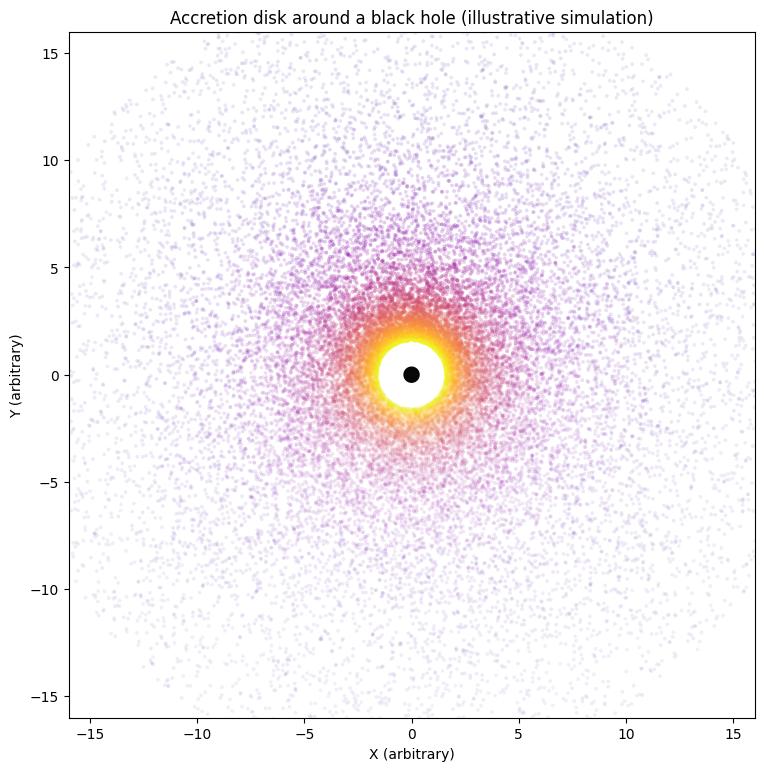

In [22]:
# =========================================================
# [ANIM_BH_001|Cell X] Black hole + accretion disk (Variant A, NO spiral arms)
#   Doppler boosting + thin-disk temperature profile (illustrative)
#   Source: synthetic (no CSV)
#   Output: MP4 via bootstrap save_animation() into ANIM_DIR
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ---------------------------------------------------------
# Black hole + disk model (separate objects)
# ---------------------------------------------------------
class BlackHole:
    def __init__(self, r_g=0.35, r_isco=1.6):
        self.r_g = float(r_g)
        self.r_isco = float(r_isco)

    def clip_R(self, R, r_out):
        return np.clip(R, self.r_isco, r_out)


class AccretionDisk:
    """
    Toy accretion disk (NO spiral arms):
    - Keplerian shear Omega ~ R^(-3/2)
    - inward drift v_r < 0
    - turbulence in R,phi (random walk)
    - birth/death respawn to prevent persistent tracks

    Visual:
    - temperature profile T ~ R^(-3/4)
    - Doppler boosting (beaming-ish) for inclined disk
    """
    def __init__(
        self,
        bh: BlackHole,
        n=26000,
        r_in=1.7,
        r_out=18.5,
        seed=7,

        omega_scale=0.95,

        vr0=0.012,
        vr_pow=1.7,

        sigma_R0=0.03,
        sigma_phi0=0.020,

        life_min_frac=0.35,
        life_max_frac=0.80,

        f_diffuse=0.25,

        incl_deg=55.0,
        beta0=0.35,
        doppler_power=3.0,
        temp_gamma=0.85,
    ):
        self.bh = bh
        self.n = int(n)
        self.r_in = float(r_in)
        self.r_out = float(r_out)
        self.rng = np.random.default_rng(seed)

        self.omega_scale = float(omega_scale)
        self.vr0 = float(vr0)
        self.vr_pow = float(vr_pow)

        self.sigma_R0 = float(sigma_R0)
        self.sigma_phi0 = float(sigma_phi0)

        self.life_min_frac = float(life_min_frac)
        self.life_max_frac = float(life_max_frac)
        self.f_diffuse = float(f_diffuse)

        self.incl = np.deg2rad(float(incl_deg))
        self.beta0 = float(beta0)
        self.doppler_power = float(doppler_power)
        self.temp_gamma = float(temp_gamma)

        self.R = None
        self.phi = None
        self.w0 = None

        self.t_birth = None
        self.t_death = None

        self._init_particles()

    def _sample_R_surface_density(self, n):
        # softened surface density ~ R^{-p}, p~1
        p = 1.0
        u = self.rng.uniform(0, 1, size=n)
        if abs(p - 1.0) < 1e-9:
            R = self.r_in * (self.r_out / self.r_in) ** u
        else:
            a = 1.0 - p
            R = (u * (self.r_out**a - self.r_in**a) + self.r_in**a) ** (1.0 / a)
        R *= self.rng.normal(1.0, 0.02, size=n)
        return np.clip(R, self.r_in, self.r_out)

    def _init_particles(self):
        R = self._sample_R_surface_density(self.n)
        phi = self.rng.uniform(0, 2*np.pi, size=self.n)

        # diffuse component
        n_diff = int(self.f_diffuse * self.n)
        if n_diff > 0:
            idx = self.rng.choice(self.n, size=n_diff, replace=False)
            R[idx] = self.rng.uniform(self.r_in, self.r_out, size=n_diff)
            phi[idx] = self.rng.uniform(0, 2*np.pi, size=n_diff)

        # base emissivity weight (inner brighter)
        Rt = 7.0
        w = np.exp(-(R - self.r_in) / Rt)
        w = 0.18 + 0.82 * (w / (w.max() + 1e-9))

        self.R = R.astype(float)
        self.phi = phi.astype(float)
        self.w0 = w.astype(float)

        self.t_birth = np.zeros(self.n, dtype=float)
        self.t_death = np.full(self.n, np.inf, dtype=float)

    def set_time_window_for_lifetimes(self, t0, t1):
        T = float(t1 - t0)
        self.t_birth = self.rng.uniform(t0, t1, size=self.n)
        life = self.rng.uniform(self.life_min_frac, self.life_max_frac, size=self.n) * T
        self.t_death = self.t_birth + life

    def respawn(self, idx, t_now, t0, t1):
        k = len(idx)
        if k == 0:
            return
        self.R[idx] = self._sample_R_surface_density(k)
        self.phi[idx] = self.rng.uniform(0, 2*np.pi, size=k)

        Rt = 7.0
        w = np.exp(-(self.R[idx] - self.r_in) / Rt)
        w = 0.18 + 0.82 * (w / (w.max() + 1e-9))
        self.w0[idx] = w

        self.t_birth[idx] = t_now
        life = self.rng.uniform(self.life_min_frac, self.life_max_frac, size=k) * (t1 - t0)
        self.t_death[idx] = t_now + life

    # --------- dynamics ---------
    def omega_kepler(self, R):
        R_eff = np.clip(R, self.bh.r_isco, None)
        return self.omega_scale * (R_eff ** (-1.5))

    def v_inward(self, R):
        R_eff = np.clip(R, self.bh.r_isco, None)
        return -self.vr0 * (R_eff / self.r_in) ** (-self.vr_pow)

    # --------- visuals ---------
    def temp_profile(self, R):
        R_eff = np.clip(R, self.bh.r_isco, None)
        T = (R_eff / self.bh.r_isco) ** (-0.75)
        Tn = (T - T.min()) / (T.max() - T.min() + 1e-9)
        return np.clip(Tn ** self.temp_gamma, 0.0, 1.0)

    def doppler_factor(self, R, phi):
        R_eff = np.clip(R, self.bh.r_isco, None)
        beta = self.beta0 * np.sqrt(self.bh.r_isco / R_eff)
        beta = np.clip(beta, 0.0, 0.65)

        cos_theta = np.sin(self.incl) * np.sin(phi)
        gamma = 1.0 / np.sqrt(1.0 - beta**2 + 1e-9)

        D = 1.0 / (gamma * (1.0 - beta * cos_theta) + 1e-9)
        return np.clip(D, 0.4, 3.0)

    def step(self, t, dt, t0, t1):
        if dt <= 0:
            alive = (t >= self.t_birth) & (t <= self.t_death)
            x = self.R * np.cos(self.phi)
            y = self.R * np.sin(self.phi)
            return x, y, self.w0, alive

        expired = (t > self.t_death)
        notborn = (t < self.t_birth)
        idx = np.where(expired | notborn)[0]
        if len(idx) > 0:
            self.respawn(idx, t_now=t, t0=t0, t1=t1)

        # inward drift
        vr = self.v_inward(self.R)
        self.R = self.bh.clip_R(self.R + vr * dt, self.r_out)

        # rotation
        Omega = self.omega_kepler(self.R)
        self.phi = self.phi + Omega * dt

        # turbulence
        sqrt_dt = np.sqrt(dt)
        dR = self.rng.normal(0.0, self.sigma_R0 * self.R * sqrt_dt, size=self.n)
        dphi = self.rng.normal(0.0, self.sigma_phi0 * sqrt_dt, size=self.n)

        self.R = self.bh.clip_R(self.R + dR, self.r_out)
        self.phi = (self.phi + dphi) % (2*np.pi)

        alive = (t >= self.t_birth) & (t <= self.t_death)

        # emissivity + flicker
        x = self.R * np.cos(self.phi)
        y = self.R * np.sin(self.phi)

        flicker = self.rng.normal(1.0, 0.06, size=self.n)
        w = np.clip(self.w0 * flicker, 0.03, 1.0)
        return x, y, w, alive


# ---------------------------------------------------------
# Build scene
# ---------------------------------------------------------
bh = BlackHole(r_g=0.35, r_isco=1.6)

disk = AccretionDisk(
    bh=bh,
    n=26_000,
    r_in=1.7,
    r_out=18.5,
    seed=7,
    omega_scale=0.95,
    vr0=0.012,
    vr_pow=1.7,
    sigma_R0=0.030,
    sigma_phi0=0.020,
    life_min_frac=0.35,
    life_max_frac=0.80,
    f_diffuse=0.25,
    incl_deg=55.0,
    beta0=0.35,
    doppler_power=3.0,
    temp_gamma=0.85,
)

# ---------------------------------------------------------
# Animation settings (uses bootstrap FPS/DPI/export config)
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS_LOCAL = 30
BASE_FRAMES = int(DURATION_SEC * FPS_LOCAL)

t0, t1 = 0.0, 40.0
times = np.linspace(t0, t1, BASE_FRAMES)

# Hold last frame
HOLD_SEC = 3.0
HOLD_FRAMES = int(HOLD_SEC * FPS_LOCAL)
times = np.concatenate([times, np.full(HOLD_FRAMES, times[-1])])

disk.set_time_window_for_lifetimes(t0, t1)

# -----------------------------
# 0) i18n
# -----------------------------
X_X = L("x_arb")          # default: "X (arb. units)"
Y_Y = L("y_arb")          # default: "Y (arb. units)"
TITLE = T("bh_disk_title")  # default: "Accretion disk around a black hole (illustrative simulation)"
# TIME_FMT = L("time_fmt_arb") # default: "t = {t:5.1f}  (arb. units)"

# -----------------------------
# Figure
# -----------------------------
lim = 16.0
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(X_X)
ax.set_ylabel(Y_Y)
ax.set_title(TITLE)

theta = np.linspace(0, 2*np.pi, 512)

# event horizon-ish (visual only)
ax.fill(bh.r_g*np.cos(theta), bh.r_g*np.sin(theta), color="black", zorder=10, alpha=0.97)

# ISCO ring
ax.plot(bh.r_isco*np.cos(theta), bh.r_isco*np.sin(theta),
        color="white", alpha=0.10, lw=1.4, zorder=1)

# subtle guide rings
for rr, lw, a in [(3.0, 1.2, 0.07), (6.0, 1.0, 0.06), (10.0, 1.0, 0.05), (15.0, 1.0, 0.04)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), color="white", alpha=a, lw=lw, zorder=0)

sc = ax.scatter([], [], s=7.5, linewidths=0, zorder=3)

# time_txt = ax.text(
#    0.02, 0.98, "",
#    transform=ax.transAxes,
#    ha="left", va="top",
#    fontsize=12,
#    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
#    color="white",
#    zorder=20
#)

# ---------------------------------------------------------
# RGBA mapping: emissivity + temperature color + Doppler boost
# ---------------------------------------------------------
cmap = plt.get_cmap("plasma")

def rgba_from_state(R, phi, w, alive):
    Tn = disk.temp_profile(R)         # 0..1
    rgb = cmap(Tn)[:, :3]             # Nx3

    D = disk.doppler_factor(R, phi)
    boost = np.clip(D ** disk.doppler_power, 0.35, 6.0)

    alpha = np.clip(0.02 + 0.22 * (w ** 1.10) * boost, 0.0, 0.95)
    alpha *= alive.astype(float)

    rgba = np.zeros((len(R), 4), dtype=float)
    rgba[:, :3] = rgb
    rgba[:, 3]  = alpha
    return rgba

# ---------------------------------------------------------
# Animation
# ---------------------------------------------------------
def init():
    sc.set_offsets(np.zeros((0, 2)))
    sc.set_facecolors(np.zeros((0, 4)))
    # time_txt.set_text("")
    return []

def update(i):
    t = float(times[i])
    dt = 0.0 if i == 0 else float(times[i] - times[i-1])

    x, y, w, alive = disk.step(t=t, dt=dt, t0=t0, t1=t1)

    sc.set_offsets(np.column_stack([x, y]))
    sc.set_facecolors(rgba_from_state(disk.R, disk.phi, w, alive))

    # time_txt.set_text(TIME_FMT.format(t=t))
    return []
    

# ---------------------------------------------------------
# Save (two lines)
# ---------------------------------------------------------
anim = FuncAnimation(fig, update, frames=len(times), init_func=init, blit=False, interval=1000/FPS_LOCAL)
save_animation(anim, anim_base("BH_001_accretion_disk_doppler_temp"))
save_last_frame(anim, "Figure_9")


plt.show()

*Figure 9.* Black hole accretion with Doppler shift effect.

---

## Conclusion

This notebook brings together a **set of complementary, intentionally schematic animations** that illustrate key processes shaping galactic disks and accretion flows, without aiming for full dynamical self-consistency. Across all cells, the emphasis is on **visual intuition**: isolating individual effects, reducing dimensionality where useful, and keeping the parameter space explicit and tunable.

For the **galactic disk**, several viewpoints are explored. Face-on 2D animations combine differential rotation with radial migration, spiral-arm–like density waves, and longitudinal traveling waves, while a dedicated **1D inside-out schematic** strips away azimuthal motion entirely to clarify how birth radii, migration amplitudes, and present-day anchors relate. Taken together, these views highlight how stars can migrate significantly in radius while spiral patterns propagate through the disk as kinematic or density features rather than material arms.

The final section extends the same philosophy to a different regime: a **black hole accretion disk**. Here, synthetic tracer particles, Keplerian shear, inward drift, turbulence, temperature gradients, and Doppler boosting are combined to produce a visually plausible accretion flow. As with the galactic disk examples, the goal is not precise modeling but a controlled, explainable illustration of how individual ingredients shape what an observer might see.

Throughout the notebook, a consistent code pattern is used: CSV-only inputs where applicable, local “physics-ish” parametrizations, minimal and plot-only i18n, and a shared bootstrap for styling and animation export. This makes the cells easy to reuse, adapt, and extend, while keeping the notebook readable as a **visual laboratory** for exploring disk dynamics and related astrophysical concepts.